# Model interpretability study on ImRex

## Libraries import

In [1]:
%matplotlib inline 

# base libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as P
import numpy as np
import tensorflow as tf
import pandas as pd

# misc
import json as js
import PIL.Image
import saliency.core as saliency
from sklearn import preprocessing
import os
import pickle as pkl

# bio data management
from Bio.PDB import PDBParser, Selection
from Bio.Data.IUPACData import protein_letters_3to1
from Bio import Align

# web scraping soup
from bs4 import BeautifulSoup
import requests
import urllib.request 

# web scraping selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait       
from selenium.webdriver.common.by import By       
from selenium.webdriver.support import expected_conditions as EC
import time
import os
from zipfile import ZipFile

# ttest
import scipy.stats

#### Run the model to generate the predictions

In [2]:
# Components of the command string:
# 1) path to the ImRex's predict.py script 
# 2) --model followed by the path to the pretrained ImRex model
# 3) --input followed by the path to the input sequences
# 4) --ouput followed by the path where to save the output
# 5) --images_dir followed by path to the directory where to save the generated property maps

 
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/input-sequences.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-predictions.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/


2021-08-15 22:25:44,821 - root - INFO - CLI argument batch_size: 128
2021-08-15 22:25:44,821 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-15 22:25:44,821 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-15 22:25:44,821 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-15 22:25:44,821 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/'
2021-08-15 22:25:44,821 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/input-sequences.csv'
2021-08-15 22:25:44,821 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-15 22:25:44,821 - root - INFO - CLI argument max_length_epitope: 11
2021-08-15 22:25:44,821 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-15 22:25:44,821 - root - INFO - CLI argument min_length_epitope: 8
2021-08-15 22:25:44,822 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-0

In [3]:
# import of the model object and some directories
model = tf.keras.models.load_model("/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5")
# directory where the generated property maps will the saved by predict.py
img_path = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images/'
work_dir = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/'

In [4]:
# load images saved with pickle during the execution predict.py
pickles = []
for f in sorted(os.listdir(img_path)):
    try:
        with open(img_path+f,'rb') as fil:
            x = pkl.load(fil)
            pickles.append(x)
    except:
        pass
        
pickles = tf.convert_to_tensor(pickles) # conversion to tensor of the list
pickles = tf.cast(pickles, tf.float32) # cast to float
pickles.shape # [number of images, 20, 11, 4]

TensorShape([9, 20, 11, 4])

In [5]:
# function to determine the prediction for each image given by the model
def predictions(img):
    image_batch = tf.expand_dims(img, 0)
    prob = model(image_batch)
    prediction = tf.math.round(prob)
    return prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


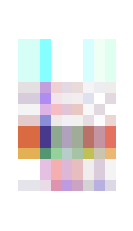

Prediction: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


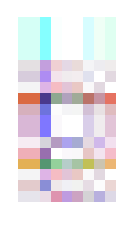

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


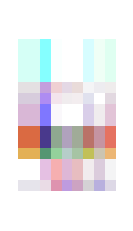

Prediction: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


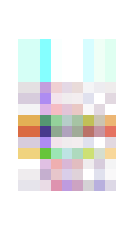

Prediction: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


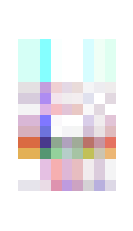

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


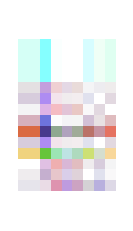

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


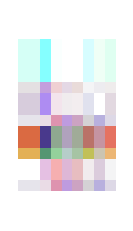

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 1


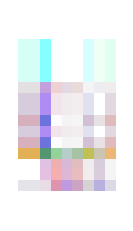

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prediction: 0


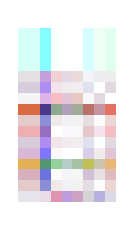

In [6]:
for p in pickles:
    
    prediction = predictions(p)
    prediction = int(prediction.numpy())
    print('Prediction: ' + str(prediction))
    
    plt.imshow(p)
    plt.axis('off')
    plt.show()

## Integrated Gradients: from scratch implementation
###### [From the TensorFlow documentation](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)

Integrated Gradients aim to accumulate pixel local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability.

Required steps:

1) interpolate small steps along a straight line in the feature space between a baseline and the input pixel's value

2) compute gradients at each step between the model's predictions with respect to each step

3) approximate the integral between the baseline and input by accumulating these local gradients.


A baseline is an input image used as a starting point for calculating feature importance (it represents the impact of the absence of each pixel prediction to contrast with its impact of each pixel on the prediction when present in the input image). The choice of the baseline has therefore high impact on the visualization of the feature's importance.

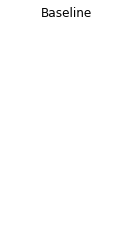

In [7]:
# definition of the baseline
baseline = tf.zeros(shape=(20,11,4)) # Baseline for CMYK format. The picture is white in this 4-channel case
                                     # It will stay the baseline for the remainder of the notebook
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

### Linear interpolation path between baseline and input images at alpha intervals

In [8]:
m_steps=40 # number of interpolation steps chosen
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # levels of transparency for each step

In [9]:
# fuction to generate the linear interpolations
def generate_path_inputs(baseline,
                         input,
                         alphas):
  # Expand dimensions for vectorized computation of interpolations.
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(input, axis=0) 
    delta = input_x - baseline_x
    path_inputs = baseline_x +  alphas_x * delta
  
    return path_inputs

In [10]:
# generate the interpolated images
path_inputs = generate_path_inputs(
    baseline=baseline, 
    input=pickles[0],
    alphas=alphas)

path_inputs.shape # [number of steps + 1, 20, 11, 4]

TensorShape([41, 20, 11, 4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


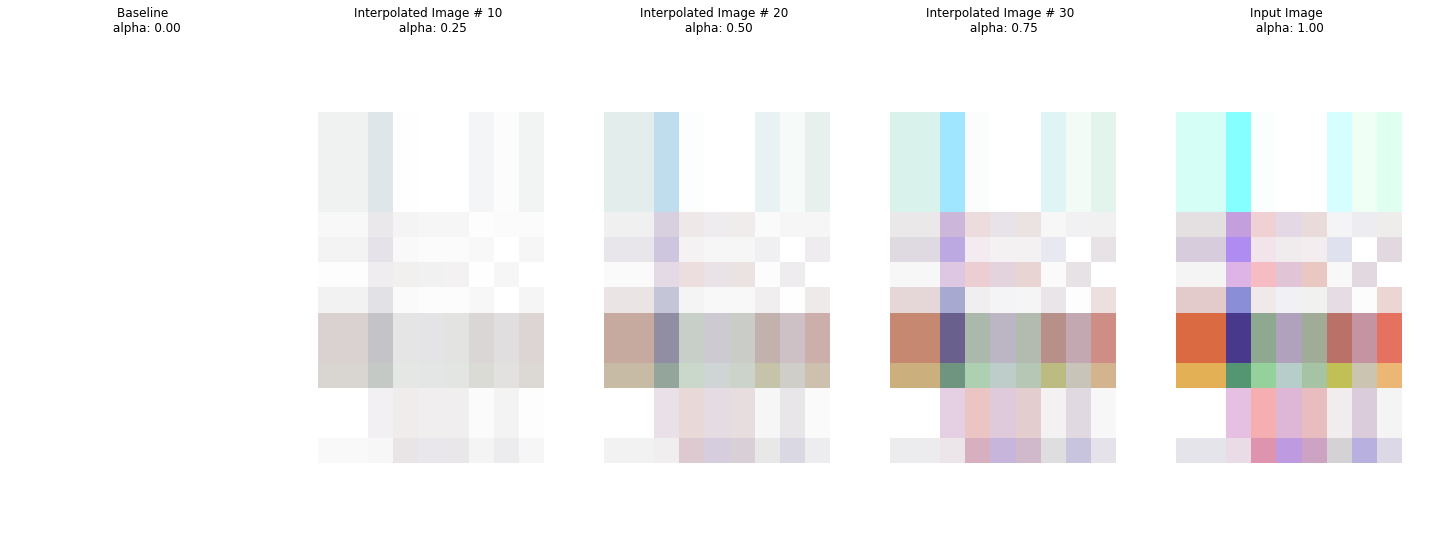

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(20, 11))

axs[0,0].set_title('Baseline \n alpha: {:.2f}'.format(alphas[0]))
axs[0,0].imshow(path_inputs[0])
axs[0,0].axis('off')

axs[0,1].set_title('Interpolated Image # 10 \n alpha: {:.2f}'.format(alphas[10]))
axs[0,1].imshow(path_inputs[10])
axs[0,1].axis('off')

axs[0,2].set_title('Interpolated Image # 20 \n alpha: {:.2f}'.format(alphas[20]))
axs[0,2].imshow(path_inputs[20])
axs[0,2].axis('off')

axs[0,3].set_title('Interpolated Image # 30 \n alpha: {:.2f}'.format(alphas[30]))
axs[0,3].imshow(path_inputs[30])
axs[0,3].axis('off')

axs[0,4].set_title('Input Image \n alpha: {:.2f}'.format(alphas[-1]))
axs[0,4].imshow(path_inputs[-1])
axs[0,4].axis('off')

plt.tight_layout()

###  Gradients computation:
#### Measures the relationship between changes to a feature and changes in the model's predictions, thus identifying which pixels have the strongest effect on the models predicted class probabilities.

In [12]:
# function to compute gradients
import math
def compute_gradients(model, path_inputs):

    with tf.GradientTape() as tape:
        tape.watch(path_inputs) # define on what to calculate the gradients
        outputs = model(path_inputs)
        
    # gradients calculated between probabilities for the target class 
    # on each interpolated image with respect to each interpolated input
    gradients = tape.gradient(outputs, path_inputs)
    
    return gradients

In [13]:
# Let's calculate the gradients for each image along the interpolation path with respect to the correct output
path_gradients = compute_gradients(
    model=model, 
    path_inputs=path_inputs)
path_gradients.shape

TensorShape([41, 20, 11, 4])

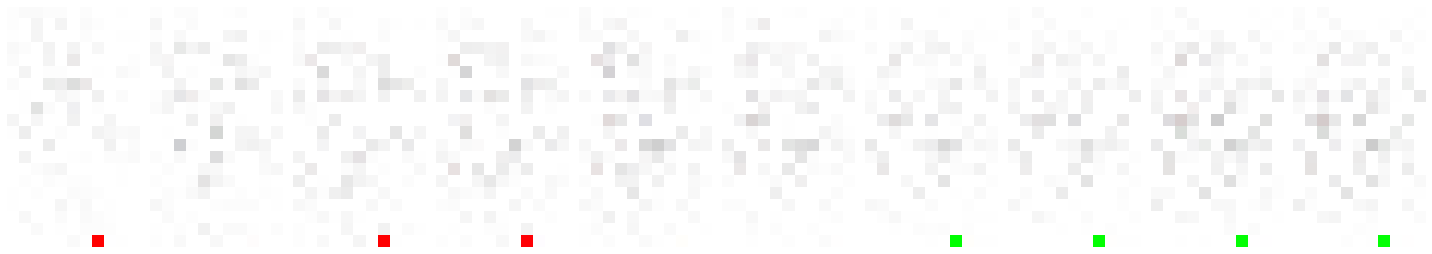

In [14]:
# plot of some of the gradients calculated
fig, axs = plt.subplots(nrows=1, ncols=10, squeeze=False, figsize=(20, 11))
for i in range(10):
    axs[0,i].imshow(tf.cast(255 * path_gradients[i*4], tf.uint8), cmap=plt.cm.viridis)
    axs[0,i].axis('off')
plt.tight_layout()

### Integral approximation:
#### Solves the problem of discontinuous gradient feature importances by taking small steps in the feature space to compute local gradients between predictions and inputs across the feature space and then averages these gradients together to produce feature attributions.

In [15]:
def integral_approximation(gradients, 
                           method='riemann_trapezoidal'):

    # different ways to compute the numeric approximation with different tradeoffs
    # riemann trapezoidal usually the most accurate
    if method == 'riemann_trapezoidal':  
        grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    elif method == 'riemann_left':
        grads = gradients
    elif method == 'riemann_midpoint':
        grads = gradients
    elif method == 'riemann_right':    
        grads = gradients
    else:
        raise AssertionError("Provided Riemann approximation method is not valid.")

    # average integration approximation
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)


    return integrated_gradients

In [16]:
ig = integral_approximation(
    gradients=path_gradients,
    method='riemann_trapezoidal')

### Attributions visualization

In [17]:
def plot_img_attributions(baseline,
                          image,
                          cmap=None,
                          overlay_alpha=0.4):

    attributions = (image - baseline) * ig

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


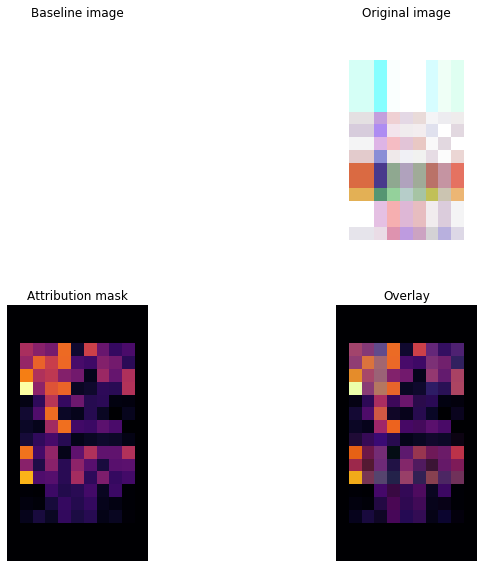

In [18]:
_ = plot_img_attributions(image=pickles[0],
                          baseline=baseline,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

## Integrated Gradients: saliency maps implementation
##### [From the library on GitHub](https://github.com/PAIR-code/saliency)

In [19]:
# Some functions to plot the masks and the images
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')

    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

In [81]:
class_idx_str = 'class_idx_str'
# definition of the function to compute the gradients, it will be passed to the various saliency techniques functions
def call_model_function(images, call_model_args=None, expected_keys=None):
    target_class_idx =  call_model_args[class_idx_str]
    images = tf.convert_to_tensor(images)
    with tf.GradientTape() as tape:
            tape.watch(images)
            output_layer = model(images)
            gradients = np.array(tape.gradient(output_layer, images))
            return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Preditiction: 1


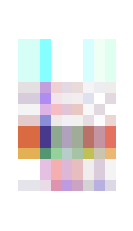

In [82]:
# Load the first image that will be used to showcase the implementations
im = pickles[0]

# Show the image
ShowImage(im)

prediction = predictions(im)
prediction = int(prediction.numpy())
print('Preditiction: ' + str(prediction))
call_model_args = {class_idx_str: prediction}

In [95]:
# Initialize the saliency objects
gradient_saliency = saliency.GradientSaliency() # Vanilla Gradients
integrated_gradients = saliency.IntegratedGradients() # Vanilla Integrated Gradients
guided_ig = saliency.GuidedIG() # Guided Integrated Gradients
xrai_object = saliency.XRAI() # XRAI
blur_ig = saliency.BlurIG() # Blur Integrated Gradients


# Visualization parameters
ROWS = 1
COLS = 3
UPSCALE_FACTOR = 15

In [96]:
# Compute masks for different techniques
# (some of them will take a while due to the high amount of computations required)
vanilla_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args) # Vanilla Gradients

smoothgrad_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args) # SmoothGrad

vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20) # Vanilla IG

guided_ig_mask_3d = guided_ig.GetMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5) # Guided IG

smoothgrad_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(
  im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, batch_size=20) # SmoothGrad IG


blur_ig_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20) # Blur IG

smooth_blur_ig_mask_3d = blur_ig.GetSmoothedMask(
    im, call_model_function, call_model_args, batch_size=20) # SmoothGrad Blur IG

In [97]:
# Convert masks to grayscale
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_mask_3d)

smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_mask_3d)

vanilla_integrated_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

guided_ig_mask_grayscale = saliency.VisualizeImageGrayscale(guided_ig_mask_3d)

smoothgrad_mask_grayscale = saliency.VisualizeImageGrayscale(smoothgrad_integrated_gradients_mask_3d)

blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(blur_ig_mask_3d)

smooth_blur_ig_mask_grayscale = saliency.VisualizeImageGrayscale(smooth_blur_ig_mask_3d)

# Compute XRAI attributions with default parameters
xrai_attributions = xrai_object.GetMask(im, call_model_function, call_model_args, batch_size=20)

### Vanilla Gradients vs SmoothGrad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


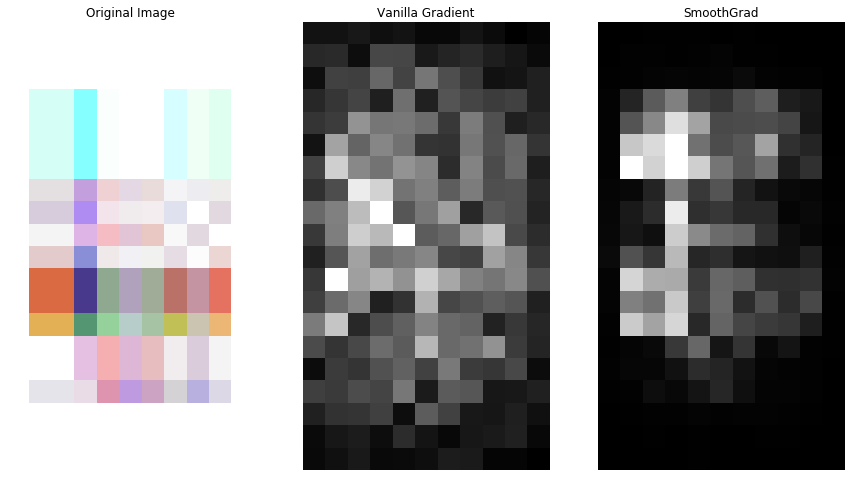

In [98]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Gradient', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='SmoothGrad', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs Guided IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


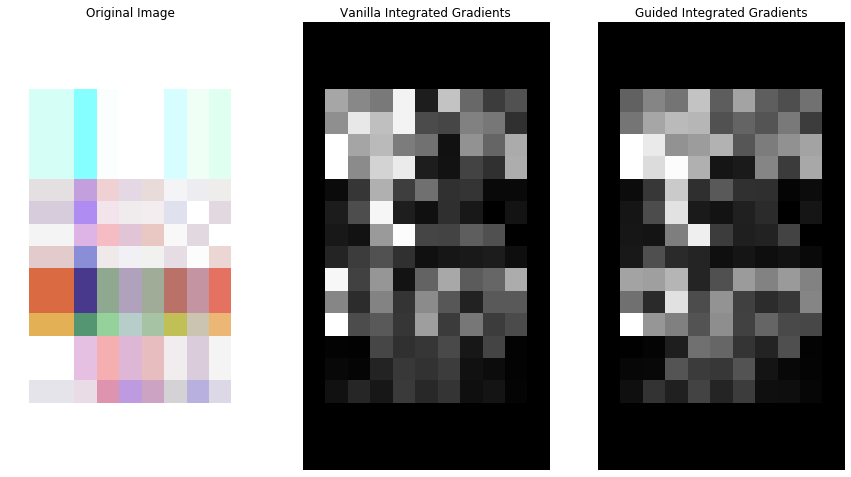

In [99]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(guided_ig_mask_grayscale, title='Guided Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs SmoothGrad IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


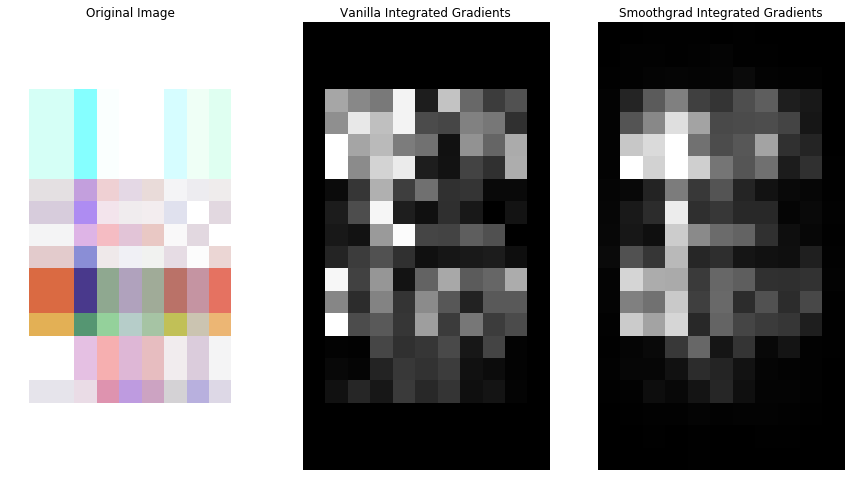

In [100]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smoothgrad_mask_grayscale, title='Smoothgrad Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### XRAI Attributions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


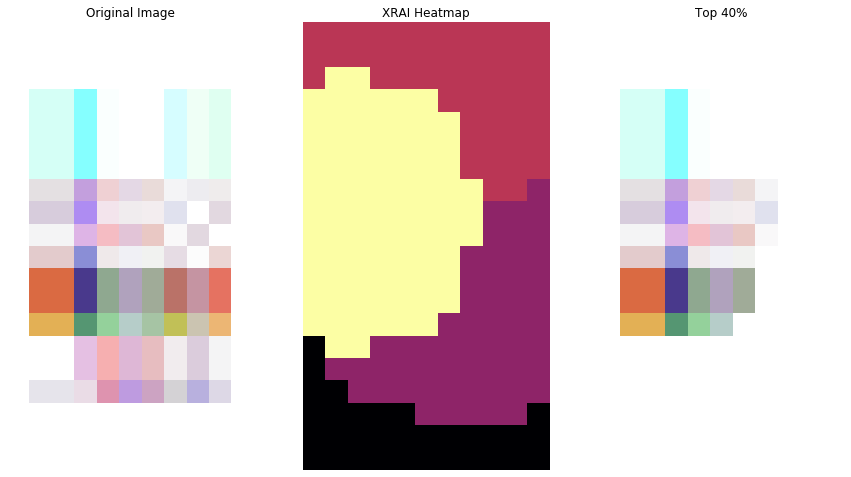

In [101]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Original image
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
# XRAI heatmap attributions
ShowHeatMap(xrai_attributions, title='XRAI Heatmap', ax=P.subplot(ROWS, COLS, 2))

# Most salient 20% of the image
mask = xrai_attributions > np.percentile(xrai_attributions, 60)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 40%', ax=P.subplot(ROWS, COLS, 3))

### Vanilla IG vs Blur IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


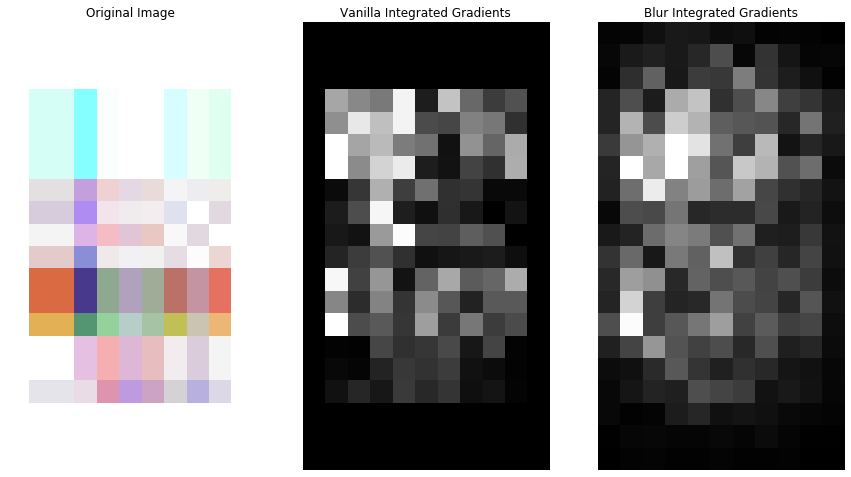

In [102]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_integrated_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 3))

### Blur IG vs SmoothGrad Blur IG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


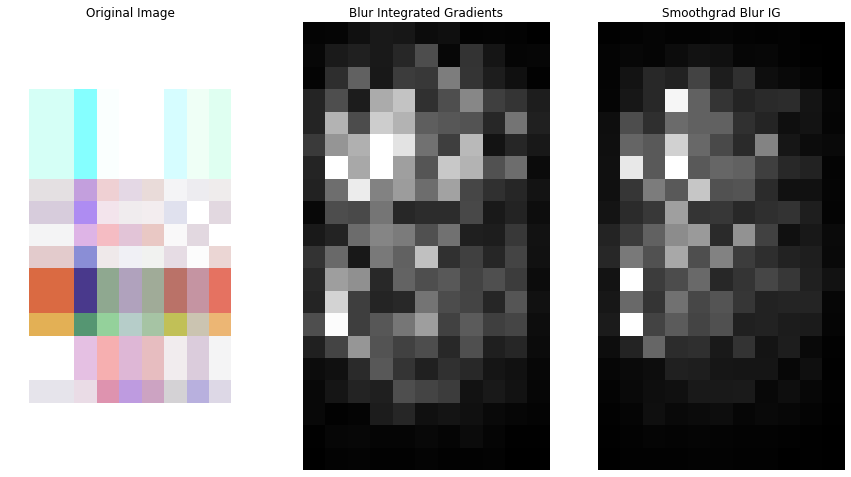

In [103]:
# Plot
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(blur_ig_mask_grayscale, title='Blur Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))
ShowGrayscaleImage(smooth_blur_ig_mask_grayscale, title='Smoothgrad Blur IG', ax=P.subplot(ROWS, COLS, 3))

# CDR3-epitope interaction data exploration

In [104]:
# the command has to be rerun to generate the new images based on the new data
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/preprocessed_vdjdb.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-predictions.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/

2021-08-17 15:41:30,811 - root - INFO - CLI argument batch_size: 128
2021-08-17 15:41:30,811 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-17 15:41:30,812 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-17 15:41:30,812 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-17 15:41:30,812 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/'
2021-08-17 15:41:30,812 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/preprocessed_vdjdb.csv'
2021-08-17 15:41:30,812 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-17 15:41:30,812 - root - INFO - CLI argument max_length_epitope: 11
2021-08-17 15:41:30,812 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-17 15:41:30,812 - root - INFO - CLI argument min_length_epitope: 8
2021-08-17 15:41:30,812 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretr

In [105]:
# a new image path is being declared since the dataset has changed
img_path_analysis = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_analysis/'

In [106]:
df = pd.read_csv(work_dir + 'output-predictions.csv')
df = df[df.y != 0] # the cases that are not interations are discarded
df = df[df.prediction_score >= 0.5] # the cases where the model has predicted a non-interaction are discarded (false negatives)
df = df.reset_index(drop=True)
df

,cdr3,antigen.epitope,y,prediction_score,im_name
0,CSVWGTGKTYEQYF,FLKEKGGL,1,0.893772,im_1
1,CSVWGEGRSYEQYF,FLKEKGGL,1,0.958685,im_2
2,CSATILAGVPYGEQYF,FLKEKGGL,1,0.932274,im_3
3,CSASEGTSSYEQYF,FLKEKGGL,1,0.823513,im_4
4,CASSFDREVTGELFF,FLKEKGGL,1,0.937733,im_5
...,...,...,...,...,...
13894,CASVTGSTDTQYF,ELKRKMIYM,1,0.909759,im_20268
13895,CASSDGTAYEQYF,ELKRKMIYM,1,0.862933,im_20269
13896,CASSLARNQPQHF,CVETMCNEY,1,0.672335,im_20270
13897,CASGGADMKTEAFF,CVETMCNEY,1,0.893031,im_20271


In [107]:
# load images saved with pickle from predict.py
pickles_analysis = [] # list of pickled Tensors
for f in df['im_name']:
    try:
        with open(img_path_analysis + str(f)+'.pkl','rb') as fil:
            x = pkl.load(fil)
            pickles_analysis.append(x)
    except Exception as e:
        print(e)
        
pickles_analysis = tf.convert_to_tensor(pickles_analysis) # conversion to tensor of the list
pickles_analysis = tf.cast(pickles_analysis, tf.float32) # cast to float
pickles_analysis.shape

TensorShape([13899, 20, 11, 4])

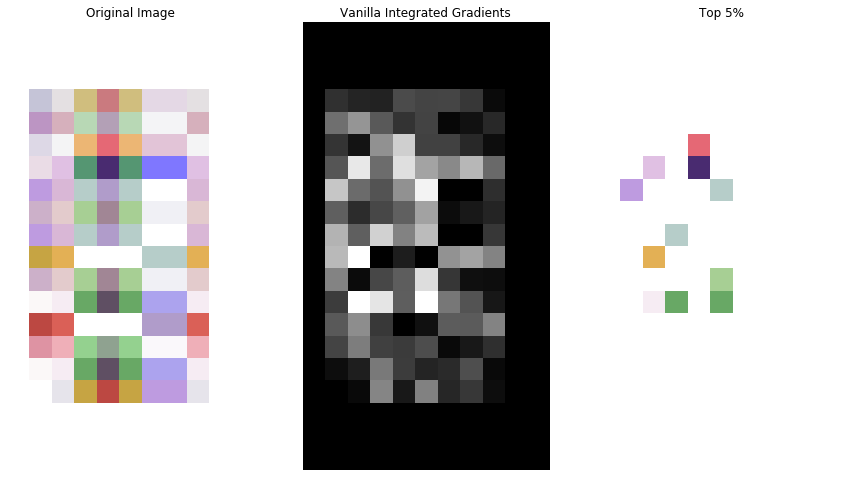

In [120]:
# Load the image
im = pickles_analysis[0]

# Compute the vanilla mask
vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
  im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)

# Call the visualization methods to convert the 3D tensor to 2D grayscale
vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)


# Render the saliency masks
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
ShowImage(im, title='Original Image', ax=P.subplot(ROWS, COLS, 1))
ShowGrayscaleImage(vanilla_mask_grayscale, title='Vanilla Integrated Gradients', ax=P.subplot(ROWS, COLS, 2))

# Show most salient 5% of the image.
# !!! The 5% of top pixels here generated keeps into account the white padding added, which should be cropped,
# this is the next step that will be implemented
mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
im_mask = np.array(im)
im_mask[~mask] = 0
ShowImage(im_mask, title='Top 5%', ax=P.subplot(ROWS, COLS, 3))

### Crop padding from the images
#### This allows to select the top relevant pixels factoring out the padded white areas of the images

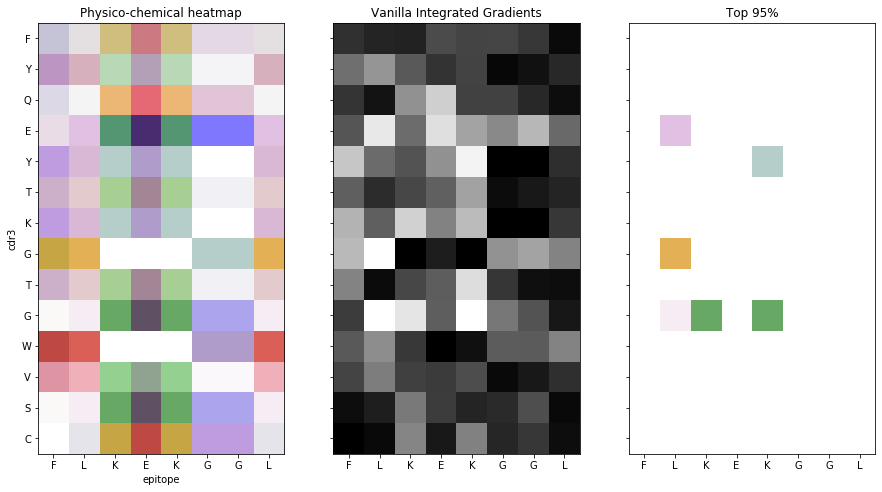

In [121]:
im_mask = np.array(im)
mask = (im_mask != 0.0).all(axis=(2)) # select all rows and columns that are not entirely white
im_mask = im_mask[(mask == True).any(axis=1),:]
im_mask = im_mask[:,(mask == True).any(axis=0)]

vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]

# select top 5% of the pixels 
r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
top_mask = np.array(im)
top_mask = top_mask[(mask == True).any(axis=1),:]
top_mask = top_mask[:,(mask == True).any(axis=0)]
top_mask[~r_mask] = 0 # set the other pixels to white

fig,(ax, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
img = ax.imshow(im_mask)
img2 = ax2.imshow(vanilla_mask_grayscale, cmap=P.cm.gray, vmin=0, vmax=1)
img3 = ax3.imshow(top_mask)


ax.set_xticks(np.arange(len(df['antigen.epitope'][0])))
ax.set_yticks(np.arange(len(df['cdr3'][0])))
ax.set_yticklabels(df['cdr3'][0][::-1])
ax.set_ylabel('cdr3')
ax.set_xlabel('epitope')
ax.set_xticklabels(df['antigen.epitope'][0])
ax.set_title("Physico-chemical heatmap")
ax2.set_title("Vanilla Integrated Gradients")
ax3.set_title("Top 95%")

fig.set_figheight(10)
fig.set_figwidth(15)
plt.show()

#### Extract the top pairs highlighted previously, for each image

In [33]:
# definition of the function for the extraction
def extract_pairs(mask, mask_grayscale, im_mask, cdr3, epitope):
    output = []
    reverse_cdr3 = cdr3[::-1] # reversing of the cdr3 sequence is needed since it is plotted from the origin moving 
                              # "upwards", following the positive y-axis direction
    relevant_indices = np.transpose(np.nonzero(mask)) # grab the non zero elements of the mask
    for pair in relevant_indices:
        res1 = reverse_cdr3[pair[0]]
        res2 = epitope[pair[1]]
        pxlv = mask_grayscale[pair[0], pair[1]]
        real_pxlv = im_mask[pair[0], pair[1]]
        # saves all the relevant information of the pixel pair
        # the sequences, the residues, their correct offsets, the property values and their IG value (grayvalue)
        output.append({'cdr3': cdr3, 'epitope': epitope, 'Res1' : res1, 'Res2': res2, 
                       'Off1' : len(cdr3)-pair[0]-1, 'Off2': pair[1], 'gray_value': pxlv,
                       'property1' : real_pxlv[0],'property2' : real_pxlv[1],'property3' : real_pxlv[2],'property4' : real_pxlv[3]})

    return(output)

In [ ]:
data = [] 

# loop to extract the pairs from each image
for i in range(df.shape[0]):
    im = pickles_analysis[i]
    
    vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(
          im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)
    
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)

    im_mask = np.array(im)
    mask = (im_mask != 0.0).all(axis=(2))
    im_mask = im_mask[(mask == True).any(axis=1),:]
    im_mask = im_mask[:,(mask == True).any(axis=0)]
    
    vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
    vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]


    r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 95)
    
    data.extend(extract_pairs(r_mask, vanilla_mask_grayscale, im_mask,
                              df['cdr3'][i], df['antigen.epitope'][i]))
    if not(i%100):
        print(i)
# save the pairs found to a csv file to easily access the data if needed,
# since this past operation is very time consuming
pairings = pd.DataFrame(data)

pairings.to_csv('pairings.csv',index=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [129]:
pairings = pd.read_csv('pairings.csv')
pairings

,cdr3,epitope,Res1,Res2,Off1,Off2,gray_value,property1,property2,property3,property4
0,CSVWGTGKTYEQYF,FLKEKGGL,E,L,10,1,0.908726,0.522222,0.000000,0.565602,0.250000
1,CSVWGTGKTYEQYF,FLKEKGGL,Y,K,9,4,0.956598,0.388889,0.591687,0.550649,0.468750
2,CSVWGTGKTYEQYF,FLKEKGGL,G,L,6,1,1.000000,0.855556,0.591687,0.116250,0.750000
3,CSVWGTGKTYEQYF,FLKEKGGL,G,L,4,1,1.000000,0.566667,0.000112,0.387242,0.078125
4,CSVWGTGKTYEQYF,FLKEKGGL,G,K,4,2,0.896325,0.288889,0.591799,0.270992,0.828125
...,...,...,...,...,...,...,...,...,...,...,...
94499,CASSPGGGKETQYF,DEEDAIAAY,G,D,6,3,0.971419,0.344444,0.224850,0.449340,0.468750
94500,CASSPGGGKETQYF,DEEDAIAAY,G,A,5,4,0.988076,0.633333,0.583423,0.442049,0.546875
94501,CASSPGGGKETQYF,DEEDAIAAY,G,I,5,5,1.000000,0.933333,0.591687,0.116250,0.750000
94502,CASSPGGGKETQYF,DEEDAIAAY,G,A,5,6,1.000000,0.633333,0.583423,0.442049,0.546875


In [39]:
# calculate correlation between numeric data. Slight positive correlation for property 1,2 and 4
# while the 3rd is slightly negativly correlated with the relevance the pixel has
pairings.drop(columns=['cdr3','epitope','Res1','Res2','Off1','Off2']).corr()

,gray_value,property1,property2,property3,property4
gray_value,1.000000,0.132408,0.070538,-0.023011,0.123850
property1,0.132408,1.000000,0.252962,-0.565926,0.442282
property2,0.070538,0.252962,1.000000,0.185498,0.556909
property3,-0.023011,-0.565926,0.185498,1.000000,-0.175451
property4,0.123850,0.442282,0.556909,-0.175451,1.000000


Text(0.5, 0, 'Offset2')

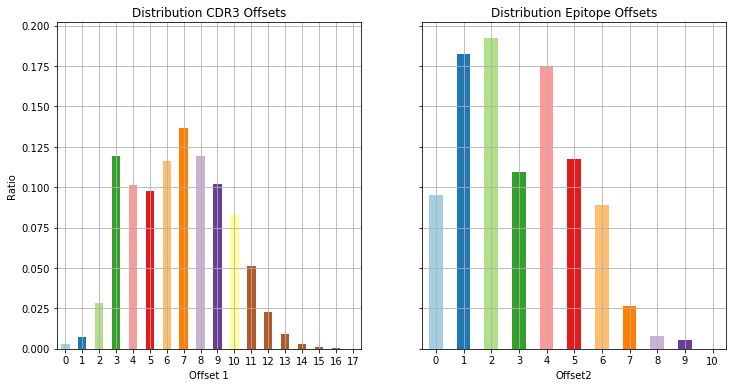

In [40]:
# plot distributions' ratios of the two sequences' offsets
# the tails see a lower ratio, with the majority of the relevant pixels distributed in the mid sections
f, axes = plt.subplots(1, 2, sharey=True)
pairings['Off1'].value_counts(normalize=True).sort_index().plot(ax=axes[0],title = 'Distribution CDR3 Offsets', color=plt.cm.Paired(np.arange(len(pairings))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))
pairings['Off2'].value_counts(normalize=True).sort_index().plot(ax=axes[1],title = 'Distribution Epitope Offsets', color=plt.cm.Paired(np.arange(len(pairings))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))
axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Offset 1")
axes[1].set_xlabel("Offset2")

   Res1  counts   total  relevance_ratio
0     A    5902  138433         0.042634
1     C     331   95158         0.003478
2     D    4453   40358         0.110337
3     E    5540   69856         0.079306
4     F    2586  139958         0.018477
5     G   15903  135766         0.117135
6     H     766   12808         0.059806
7     I    1953   25283         0.077246
8     K    1733   17604         0.098444
9     L    5370   64522         0.083227
10    M     836    8036         0.104032
11    N    5698   48403         0.117720
12    P    3846   37660         0.102124
13    Q    4627   78927         0.058624
14    R    4197   42219         0.099410
15    S   14886  188174         0.079108
16    T    7512   84961         0.088417
17    V    2728   35173         0.077559
18    W     808    8988         0.089898
19    Y    4829   76480         0.063141


Text(0.5, 0, 'Ratio of relevance')

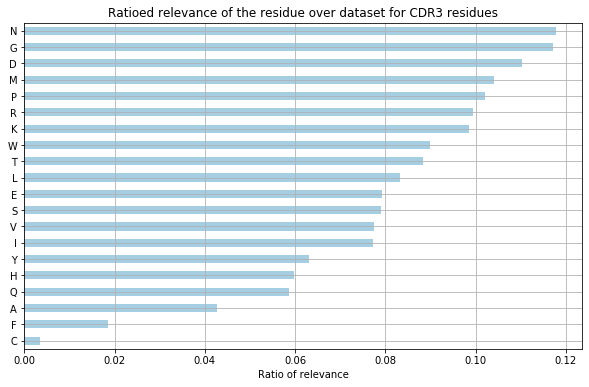

In [42]:
df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res2','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res1'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res1']).size().reset_index(name='counts')
df['total'] = df['Res1'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist()},
                         index=df['Res1'].tolist()).sort_values(by='relevance_ratio')
ax = ratioed.plot(title = 'Ratioed relevance of the residue over dataset for CDR3 residues',
                       color=plt.cm.Paired(np.arange(len(df))), kind='barh', grid = True, rot = 1, legend = False, figsize=(10,6))

ax.set_xlabel("Ratio of relevance")

   Res2  counts   total  relevance_ratio
0     A    4587  138433         0.033135
1     C     983   95158         0.010330
2     D    1257   40358         0.031146
3     E    1679   69856         0.024035
4     F    6389  139958         0.045649
5     G    6742  135766         0.049659
6     H     470   12808         0.036696
7     I   10603   25283         0.419373
8     K    2594   17604         0.147353
9     L   18127   64522         0.280943
10    M    3948    8036         0.491289
11    N    3781   48403         0.078115
12    P    3201   37660         0.084997
13    Q     356   78927         0.004510
14    R    6747   42219         0.159810
15    S     887  188174         0.004714
16    T    1170   84961         0.013771
17    V   17790   35173         0.505786
18    W    2523    8988         0.280708
19    Y     670   76480         0.008760


Text(0.5, 0, 'Ratio of relevance')

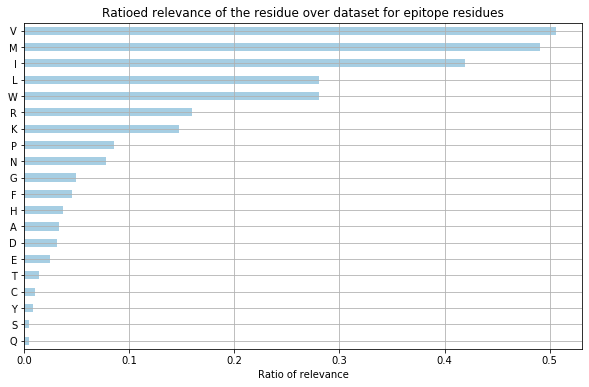

In [43]:
df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res1','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res2'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res2']).size().reset_index(name='counts')
df['total'] = df['Res2'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist()},
                         index=df['Res2'].tolist()).sort_values(by='relevance_ratio')
ax = ratioed.plot(title = 'Ratioed relevance of the residue over dataset for epitope residues',
                       color=plt.cm.Paired(np.arange(len(df))), kind='barh', grid = True, rot = 1, legend = False, figsize=(10,6))

ax.set_xlabel("Ratio of relevance")

Text(0.5, 0, 'Residues')

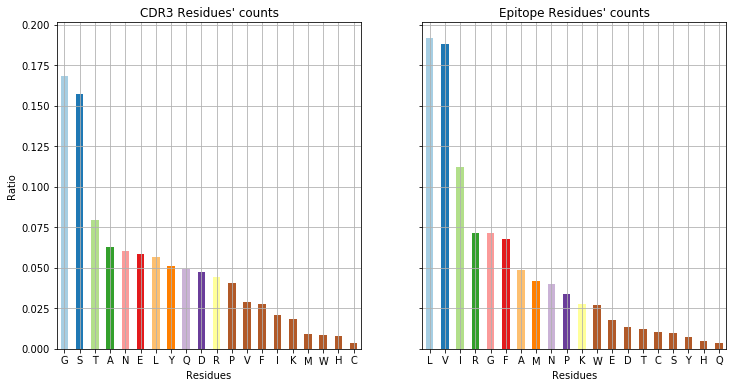

In [44]:
df1 = pd.read_csv('pairings.csv')
f, axes = plt.subplots(1, 2, sharey=True)
df1['Res1'].value_counts(normalize=True).plot(ax=axes[0],title = 'CDR3 Residues\' counts', color=plt.cm.Paired(np.arange(len(df1))),
                                                   grid = True, kind='bar', rot = 1, legend = False, figsize=(12,6))

df1['Res2'].value_counts(normalize = True).plot(ax=axes[1],title = 'Epitope Residues\' counts', color=plt.cm.Paired(np.arange(len(df1))), grid = True,
                                                     kind='bar', rot = 1, legend = False, figsize=(12,6))

axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Residues")
axes[1].set_xlabel("Residues")


   Res1  counts   total  relevance_ratio  count_ratio
0     A    5902  138433         0.042634     0.062452
1     C     331   95158         0.003478     0.003502
2     D    4453   40358         0.110337     0.047120
3     E    5540   69856         0.079306     0.058622
4     F    2586  139958         0.018477     0.027364
5     G   15903  135766         0.117135     0.168279
6     H     766   12808         0.059806     0.008105
7     I    1953   25283         0.077246     0.020666
8     K    1733   17604         0.098444     0.018338
9     L    5370   64522         0.083227     0.056823
10    M     836    8036         0.104032     0.008846
11    N    5698   48403         0.117720     0.060294
12    P    3846   37660         0.102124     0.040697
13    Q    4627   78927         0.058624     0.048961
14    R    4197   42219         0.099410     0.044411
15    S   14886  188174         0.079108     0.157517
16    T    7512   84961         0.088417     0.079489
17    V    2728   35173     

Text(0.5, 0, 'Residues')

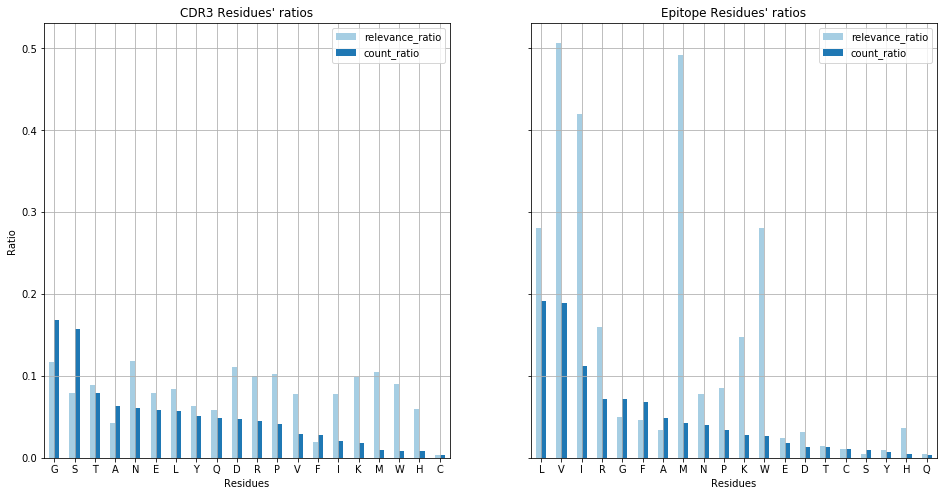

In [45]:
df = pd.read_csv('pairings.csv')
n_rows = len(df)
df.drop(columns=['epitope','Off2','Res2','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res1'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res1']).size().reset_index(name='counts')
df['total'] = df['Res1'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
df['count_ratio'] = df['counts']/n_rows
print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist(),
                       'count_ratio': df['count_ratio'].tolist()},
                         index=df['Res1'].tolist())
ratioed['count_ratio'] = df1['Res1'].value_counts(normalize=True)



df = pd.read_csv('pairings.csv')
df.drop(columns=['epitope','Off2','Res1','Off1','property1','property2','property3',
                 'property4','gray_value'],inplace = True)
for un in df['Res2'].unique():
    df[un] = df['cdr3'].str.count(un)
df.drop(columns=['cdr3'],inplace = True)
mappa = {}
for column in df.columns[1:]:
    mappa[column] = df[column].sum()
df = df.groupby(['Res2']).size().reset_index(name='counts')
df['total'] = df['Res2'].map(mappa)
df['relevance_ratio'] = df['counts']/df['total']
df['count_ratio'] = df['counts']/n_rows
print(df)
df.drop(columns=['counts','total'],inplace = True)
ratioed2 = pd.DataFrame({'relevance_ratio': df['relevance_ratio'].tolist(),
                        'count_ratio': df['count_ratio'].tolist()},
                         index=df['Res2'].tolist())



f, axes = plt.subplots(1, 2, sharey=True)
ratioed.sort_values(by=['count_ratio'], ascending=False).plot(ax=axes[0],title = 'CDR3 Residues\' ratios', color=plt.cm.Paired(np.arange(len(df1))),
                                                   grid = True, kind='bar', rot = 1, figsize=(16,8))

ratioed2.sort_values(by=['count_ratio'], ascending=False).plot(ax=axes[1],title = 'Epitope Residues\' ratios', color=plt.cm.Paired(np.arange(len(df1))), grid = True,
                                                     kind='bar', rot = 1,figsize=(16,8))

axes[0].set_ylabel("Ratio")
axes[0].set_xlabel("Residues")
axes[1].set_xlabel("Residues")

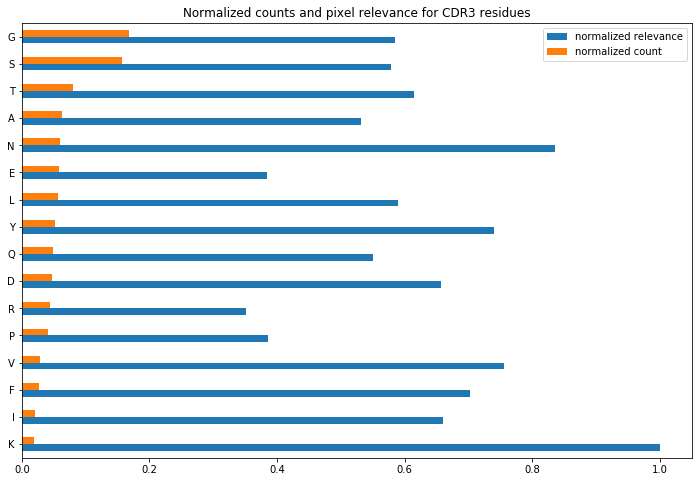

In [46]:
df2 = pd.read_csv('pairings.csv')
length = len(df2)
df2.drop(columns=['cdr3','epitope','Off2','Res2','Off1','property1','property2','property3','property4'],inplace = True)
df2['count'] = df2['Res1'].map(df2['Res1'].value_counts())
df2 = df2.groupby(['Res1','count']).sum()
df2.reset_index(inplace = True)
df2['normalized_by_freq']=df2['gray_value']/df2['count']
df2['normalized relevance']=(df2['normalized_by_freq']-df2['normalized_by_freq'].min()) / (df2['normalized_by_freq'].max()-df2['normalized_by_freq'].min())
df2['normalized count'] = df2['count']/length
coupled = pd.DataFrame({'normalized relevance': df2['normalized relevance'].tolist(),
                        'normalized count': df2['normalized count'].tolist()},
                         index=df2['Res1'].tolist()).sort_values(by='normalized count')
coupled.drop(coupled[coupled['normalized count'] < 0.01].index, inplace=True)
ax = coupled.plot.barh(title = 'Normalized counts and pixel relevance for CDR3 residues', figsize=(12,8))

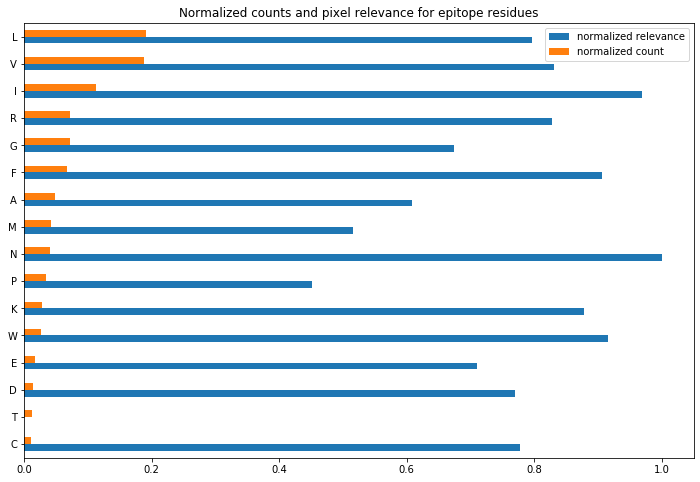

In [47]:
df3 = pd.read_csv('pairings.csv')
df3.drop(columns=['cdr3','epitope','Off2','Res1','Off1','property1','property2','property3','property4'],inplace = True)
df3['count'] = df3['Res2'].map(df3['Res2'].value_counts())
df3 = df3.groupby(['Res2','count']).sum()
df3.reset_index(inplace = True)
df3['normalized_by_freq']=df3['gray_value']/df3['count']
df3['normalized relevance']=(df3['normalized_by_freq']-df3['normalized_by_freq'].min()) / (df3['normalized_by_freq'].max()-df3['normalized_by_freq'].min())
df3['normalized count'] = df3['count']/length
coupled = pd.DataFrame({'normalized relevance': df3['normalized relevance'].tolist(),
                        'normalized count': df3['normalized count'].tolist()},
                         index=df3['Res2'].tolist()).sort_values(by='normalized count')
coupled.drop(coupled[coupled['normalized count'] < 0.01].index, inplace=True)
coupled.plot.barh(title = 'Normalized counts and pixel relevance for epitope residues', figsize=(12,8))

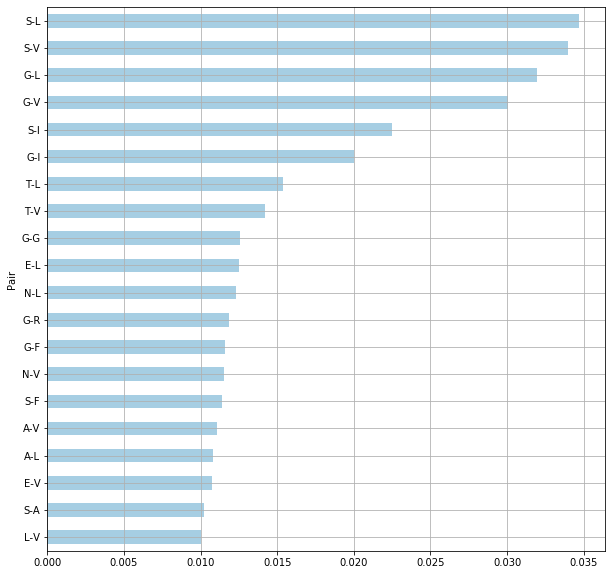

In [48]:
pairdf = pd.read_csv('pairings.csv')
n_pairs = len(pairdf)
pairdf.drop(columns=['cdr3','epitope','Off2','Off1','property1','property2','property3','property4'],inplace = True)
pairdf = pairdf.groupby(["Res1",'Res2']).size().reset_index()
pairdf = pairdf.set_axis(['Res1','Res2','CountRatio'], axis = 1)
pairdf['CountRatio'] = pairdf['CountRatio']/n_pairs
pairdf['Pair'] = pairdf['Res1'] + '-' + pairdf['Res2']
pairdf.drop(columns=['Res1','Res2'], inplace = True)
pairdf = pairdf.set_index('Pair')
pairdf.drop(pairdf[pairdf['CountRatio'] < 0.01].index, inplace=True)
pairdf.sort_values(by = 'CountRatio').plot(kind = 'barh', figsize=(10,10),color=plt.cm.Paired(np.arange(len(pairdf))), grid = True, legend = False)

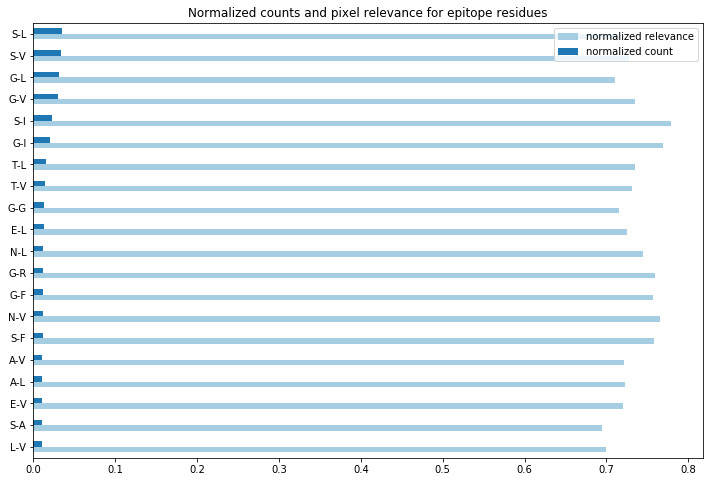

In [49]:
pairdf2 = pd.read_csv('pairings.csv')
pairdf2['Pair'] = pairdf2['Res1'] + '-' + pairdf2['Res2']
pairdf2.drop(columns=['cdr3','epitope','Off2','Off1','Res1','Res2','property1','property2','property3','property4'],inplace = True)
pairdf2['count'] = pairdf2['Pair'].map(pairdf2['Pair'].value_counts())
pairdf2 = pairdf2.groupby(['Pair', 'count']).sum()
pairdf2.reset_index(inplace = True)
pairdf2['normalized_by_freq']=pairdf2['gray_value']/pairdf2['count']
pairdf2['normalized count'] = pairdf2['count']/length
pairdf2['normalized relevance']=(pairdf2['normalized_by_freq']-pairdf2['normalized_by_freq'].min()) / (pairdf2['normalized_by_freq'].max()-pairdf2['normalized_by_freq'].min())
paired = pd.DataFrame({'normalized relevance': pairdf2['normalized relevance'].tolist(),
                        'normalized count': pairdf2['normalized count'].tolist()},
                         index=pairdf2['Pair'].tolist()).sort_values(by='normalized count')
paired.drop(paired[paired['normalized count'] < 0.01].index, inplace=True)
paired.plot.barh(title = 'Normalized counts and pixel relevance for epitope residues', figsize=(12,8),color=plt.cm.Paired(np.arange(len(pairdf))))

# 3D Analysis

In [25]:
def fasta2pdb_mapper(pdb_filepath, pdb_id, model, chain, fasta_seq):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pdb_id, pdb_filepath)
    pdb_tcrb_chain = structure[model][chain]
    pdb_tcrb_sel = Selection.unfold_entities(pdb_tcrb_chain, "R")
    pdb_tcrb_seq = ''
    pdb_tcrb_id_seq = []
    for r in pdb_tcrb_sel:
        if r.get_id()[0] == ' ':
            pdb_tcrb_seq += protein_letters_3to1[r.get_resname().title()]
            pdb_tcrb_id_seq.append(r.get_id()[1])
    aligner = Align.PairwiseAligner()
    alignment = aligner.align(pdb_tcrb_seq, fasta_seq)[0]
    pdb_aligned, fasta_aligned = alignment.aligned
    pdb2fasta_mapper = {}
    for pdb_chunck, fasta_chunk in zip(pdb_aligned, fasta_aligned):
        for pdb_chunck_id, fasta_chunk_id in zip(range(pdb_chunck[0], pdb_chunck[1]),
                                                 range(fasta_chunk[0], fasta_chunk[1])):
            pdb_numbering_id = pdb_tcrb_id_seq[pdb_chunck_id]
            pdb2fasta_mapper[pdb_numbering_id] = fasta_chunk_id
    return pdb2fasta_mapper

In [28]:
# cmd to generate the predictions based on the complex_data.csv sequences
!python /Users/fabio_air/Desktop/ImRex-master/src/scripts/predict/predict.py --model /Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001/2020-07-24_19-18-39_trbmhcidown-shuffle-padded-b32-lre4-reg001.h5 --input /Users/fabio_air/Desktop/ImRex-master/deepTCR/complex_data.csv --output /Users/fabio_air/Desktop/ImRex-master/deepTCR/output-3D.csv --images_dir /Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/

2021-08-15 22:35:35,133 - root - INFO - CLI argument batch_size: 128
2021-08-15 22:35:35,133 - root - INFO - CLI argument cdr3_column: 'cdr3'
2021-08-15 22:35:35,134 - root - INFO - CLI argument epitope_column: 'antigen.epitope'
2021-08-15 22:35:35,134 - root - INFO - CLI argument features: 'hydrophob,isoelectric,mass,hydrophil'
2021-08-15 22:35:35,134 - root - INFO - CLI argument images_dir: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/'
2021-08-15 22:35:35,135 - root - INFO - CLI argument input: '/Users/fabio_air/Desktop/ImRex-master/deepTCR/complex_data.csv'
2021-08-15 22:35:35,135 - root - INFO - CLI argument max_length_cdr3: 20
2021-08-15 22:35:35,135 - root - INFO - CLI argument max_length_epitope: 11
2021-08-15 22:35:35,135 - root - INFO - CLI argument min_length_cdr3: 10
2021-08-15 22:35:35,135 - root - INFO - CLI argument min_length_epitope: 8
2021-08-15 22:35:35,135 - root - INFO - CLI argument model: '/Users/fabio_air/Desktop/ImRex-master/models/pretrained/2020-0

In [26]:
# pdb files scraping
def scrape_pdb(file_name):
    
    pdb_dir = './pdb_files/'
    base_url = 'https://www.rcsb.org/structure/'
    
    url = base_url + file_name.lower()
    response = requests.get(url,timeout=None)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")
    
    a = soup.find('a', href=lambda x: x and x.endswith('download/' + file_name +'.pdb'))
    
    try:
        urllib.request.urlretrieve('https:' + a['href'], pdb_dir + file_name.lower() +'.pdb')
        print('Downloaded: ' + file_name.lower() +'.pdb')
    except Exception as e:
        print('Failed Download:' + e)

comps = pd.read_csv('complex_data.csv', sep=';')
comps['PDB_ID'].apply(scrape_pdb)

Downloaded: 1ao7.pdb
Downloaded: 1bd2.pdb
Downloaded: 1mi5.pdb
Downloaded: 1oga.pdb
Downloaded: 1qrn.pdb
Downloaded: 1qse.pdb
Downloaded: 1qsf.pdb
Downloaded: 2ak4.pdb
Downloaded: 2bnq.pdb
Downloaded: 2bnr.pdb
Downloaded: 2esv.pdb
Downloaded: 2f53.pdb
Downloaded: 2f54.pdb
Downloaded: 2gj6.pdb
Downloaded: 2nx5.pdb
Downloaded: 2p5e.pdb
Downloaded: 2p5w.pdb
Downloaded: 2pye.pdb
Downloaded: 2vlj.pdb
Downloaded: 2vlk.pdb
Downloaded: 2vlr.pdb
Downloaded: 2ypl.pdb
Downloaded: 3d39.pdb
Downloaded: 3d3v.pdb


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
21    None
22    None
23    None
Name: PDB_ID, dtype: object

In [27]:
def scrape_contact(file_name, epitope_chain, tcrb_chain):
    
    # directory where zip files will be downloaded
    download_dir = '/Users/fabio_air/Downloads/'
    # directory where the contact files will be placed
    contacts_dir = './contacts/'
    # directory where the chrome drive is stored
    # can be downloaded here: https://chromedriver.chromium.org/
    chromedriver_dir = '/Users/fabio_air/Downloads/chromedriver'
    # url of the site to explore
    base_url = 'https://www.mrc-lmb.cam.ac.uk/pca/redirect/'
    
    url = base_url + file_name
    
    # webdriver setup
    options = webdriver.ChromeOptions()
    options.add_argument("--disable-notifications")
    
    # uncomment this line to hide the browser during the scraping
    options.add_argument("--headless")
    driver = webdriver.Chrome(chromedriver_dir, chrome_options=options)

    driver.get(url)
    if not os.path.exists(download_dir + file_name + '_txt.zip'):
        try:
            # NOTE: the time sleeps are not the optimal solution but they are useful to allow the button
            # to become active for it to be pressed. It should be pressed when the JS behind it becomes active
            time.sleep(2) 
            WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#myModal > div > div > div.modal-header > button"))).click()
            time.sleep(2) 
            WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, "savecsv"))).click()
            
            while not os.path.exists(download_dir + file_name + '_txt.zip'):
                print('Waiting')
                time.sleep(2)
                
            print('File ' + file_name + '_txt.zip' + ' downloaded')
            driver.quit()
            
        except Exception as e:
            driver.quit()
            print(e)

    else:
        print('File ' + file_name + '_txt.zip' + ' already exists')
        driver.quit()
    
    
    # extract wanted contact file
    with ZipFile(download_dir + file_name + '_txt.zip', 'r') as zip_file:
        zip_file.extract(file_name + '_' + epitope_chain + '-' + tcrb_chain + '.txt', path = contacts_dir)
        # remove original zip file
        os.remove(download_dir + file_name + '_txt.zip')

[scrape_contact(x, y, z) for x, y, z in zip(comps['PDB_ID'], comps['epitope_chain'], comps['tcrb_chain'])]

<ipython-input-27-7e45a966e2b2>:21: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(chromedriver_dir, chrome_options=options)


Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting
Waiting


KeyboardInterrupt: 

In [29]:
comps = pd.read_csv('output-3D.csv')

In [30]:
mappings = []
for i, comp in comps.iterrows():
    mapping = fasta2pdb_mapper('./pdb_files/' + comp['PDB_ID'].lower() + '.pdb', comp['PDB_ID'], 
                     0, comp['tcrb_chain'], comp['tcrb_seq'])
    mappings.append(mapping)

In [31]:
# load images saved with pickle from predict.py
images_path = '/Users/fabio_air/Desktop/ImRex-master/deepTCR/Images_3D/'
analysis_3D = [] # list of pickled Tensors
for i, comp in comps.iterrows():
    try:
        with open(images_path + str(comp['im_name'])+'.pkl','rb') as fil:
            x = pkl.load(fil)
            analysis_3D.append(x)
    except Exception as e:
        print(e)
        
analysis_3D = tf.convert_to_tensor(analysis_3D) # conversion to tensor of the list
analysis_3D = tf.cast(analysis_3D, tf.float32) # cast to float
analysis_3D.shape

TensorShape([21, 20, 11, 4])

1AO7_C-E.txt
CASRPGLAGGRPEQYF LLFGYPVYV
   Res1 Res2  Off1  Off2
0     E    L    12     0
1     E    F    12     2
2     E    Y    12     4
3     P    L    11     1
4     P    P    11     5
5     R    Y    10     4
6     G    L     9     0
7     G    F     9     2
8     G    G     9     3
9     G    Y     9     4
10    G    P     9     5
11    G    F     8     2
12    G    G     8     3
13    G    Y     8     4
14    G    P     8     5
15    A    L     7     0
16    A    F     7     2
17    A    G     7     3
18    A    Y     7     4
19    L    F     6     2
20    L    Y     6     4
21    L    V     6     6
22    G    L     5     1
23    G    F     5     2
24    G    G     5     3
25    P    L     4     0
26    P    G     4     3
27    P    V     4     6
28    R    G     3     3
  Res1 Res2  Off1  Off2  Distance
0    R    Y     3     4   3.19614
1    L    Y     6     7   3.28626
2    P    Y    11     4   3.32289
3    L    V     6     6   3.44522
4    L    P     6     5   3.72806
5    G

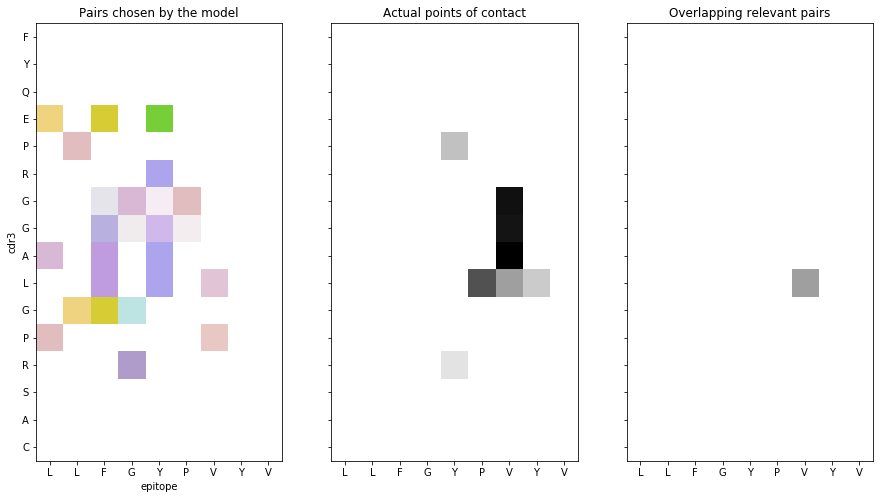

1BD2_C-E.txt
CASSYPGGGFYEQYF LLFGYPVYV
   Res1 Res2  Off1  Off2
0     E    V    11     6
1     Y    F    10     2
2     Y    G    10     3
3     Y    Y    10     4
4     Y    P    10     5
5     F    L     9     0
6     F    F     9     2
7     F    G     9     3
8     F    Y     9     4
9     F    V     9     6
10    G    F     8     2
11    G    Y     8     4
12    G    P     8     5
13    G    F     7     2
14    G    Y     7     4
15    G    P     7     5
16    G    L     6     0
17    G    L     6     1
18    G    F     6     2
19    G    G     6     3
20    G    Y     6     4
21    G    V     6     6
22    P    L     5     0
23    P    G     5     3
24    P    Y     5     4
25    P    V     5     6
26    Y    L     4     1
  Res1 Res2  Off1  Off2  Distance
0    G    Y     6     7   2.80044
1    G    V     6     6   3.19990
2    Y    Y    10     4   3.47304
3    G    P     6     5   3.73701
4    Y    V    10     6   3.76586
5    Y    Y     4     7   3.87293
6    P    V     5     6

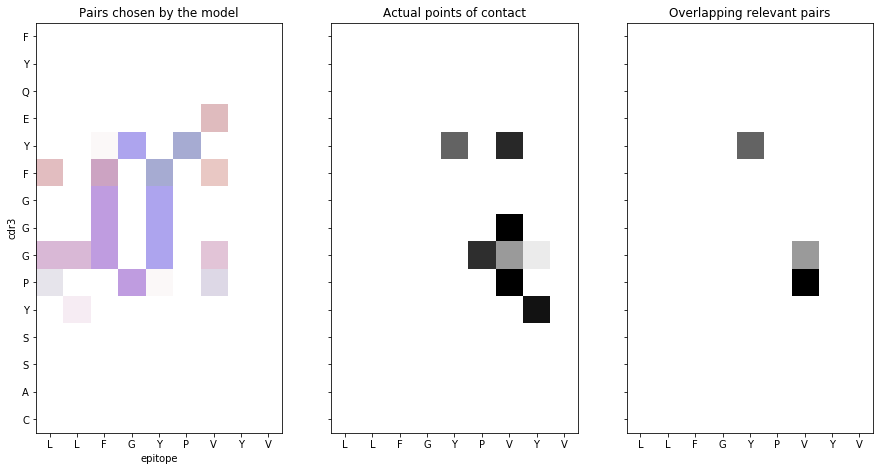

1MI5_C-E.txt
CASSLGQAYEQYF FLRGRAYGL
   Res1 Res2  Off1  Off2
0     F    R    12     4
1     Q    R    10     2
2     Q    G    10     3
3     E    F     9     0
4     E    R     9     2
5     Y    R     8     2
6     A    R     7     2
7     A    G     7     3
8     Q    F     6     0
9     Q    L     6     1
10    Q    R     6     2
11    Q    G     6     3
12    Q    R     6     4
13    Q    A     6     5
14    Q    Y     6     6
15    G    L     5     1
16    G    G     5     3
17    G    R     5     4
18    L    R     4     2
19    L    G     4     3
20    S    R     3     2
21    S    L     2     1
22    S    R     2     2
23    S    A     2     5
  Res1 Res2  Off1  Off2  Distance
0    Q    A     6     5   3.06054
1    Y    G     8     7   3.22613
2    A    Y     7     6   3.55874
3    A    A     7     5   3.59603
4    Y    Y     8     6   3.61390
  Res1 Res2  Off1  Off2  Distance
0    Q    A     6     5   3.06054


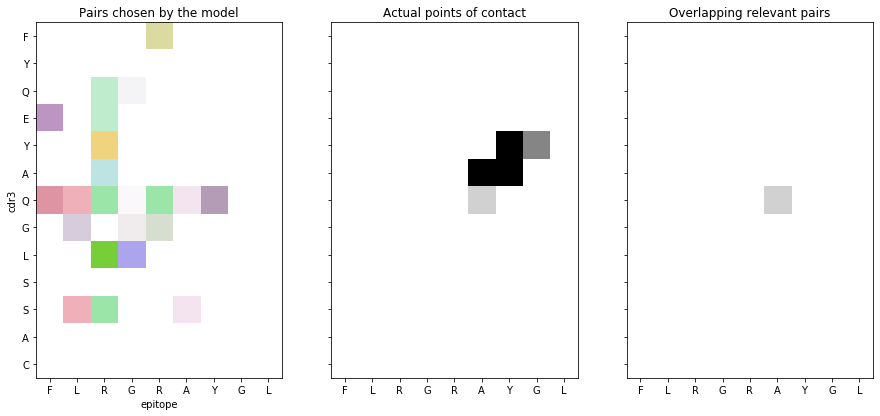

1OGA_C-E.txt
CASSSRSSYEQYF GILGFVFTL
   Res1 Res2  Off1  Off2
0     Q    G    10     3
1     Q    F    10     4
2     E    L     9     2
3     Y    I     8     1
4     Y    L     8     2
5     Y    G     8     3
6     Y    F     8     4
7     Y    V     8     5
8     S    I     7     1
9     S    L     7     2
10    S    G     7     3
11    S    F     7     4
12    S    V     7     5
13    S    I     6     1
14    S    L     6     2
15    S    G     6     3
16    S    F     6     4
17    R    F     5     4
18    R    V     5     5
19    S    F     4     4
20    S    V     4     5
21    S    G     3     3
22    S    F     3     4
23    S    V     3     5
  Res1 Res2  Off1  Off2  Distance
0    S    V     6     5   3.09078
1    R    F     5     4   3.78413
2    S    F     7     4   3.81887
3    R    F     5     6   4.16060
  Res1 Res2  Off1  Off2  Distance
0    S    F     7     4   3.81887
1    R    F     5     4   3.78413


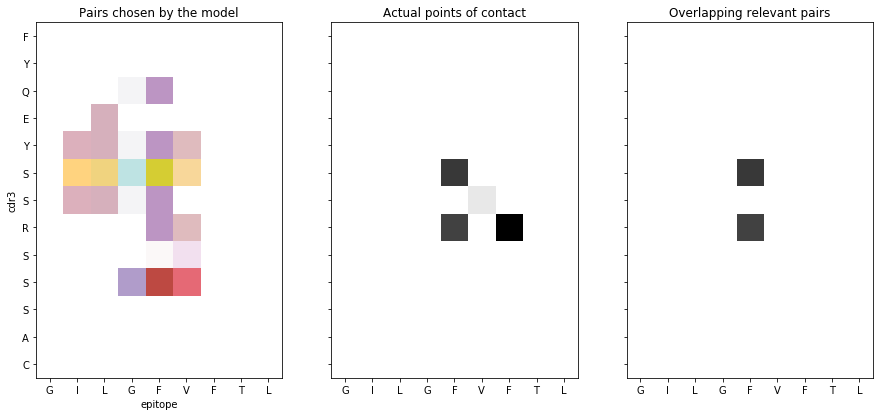

1QRN_C-E.txt
CASRPGLAGGRPEQYF LLFGYAVYV
   Res1 Res2  Off1  Off2
0     E    G    12     3
1     P    L    11     1
2     P    G    11     3
3     R    L    10     1
4     R    Y    10     4
5     R    A    10     5
6     G    F     9     2
7     G    Y     9     4
8     G    A     9     5
9     G    L     8     0
10    G    F     8     2
11    G    G     8     3
12    G    Y     8     4
13    G    A     8     5
14    G    V     8     6
15    A    L     7     0
16    A    F     7     2
17    A    G     7     3
18    A    Y     7     4
19    A    A     7     5
20    A    V     7     6
21    L    G     6     3
22    L    A     6     5
23    G    L     5     1
24    G    F     5     2
25    P    F     4     2
26    P    G     4     3
27    P    A     4     5
28    R    G     3     3
  Res1 Res2  Off1  Off2  Distance
0    L    Y     6     7   3.04226
1    P    Y    11     4   3.31318
2    L    A     6     5   3.40197
3    L    V     6     6   3.40660
4    A    V     7     6   3.52425
5    R

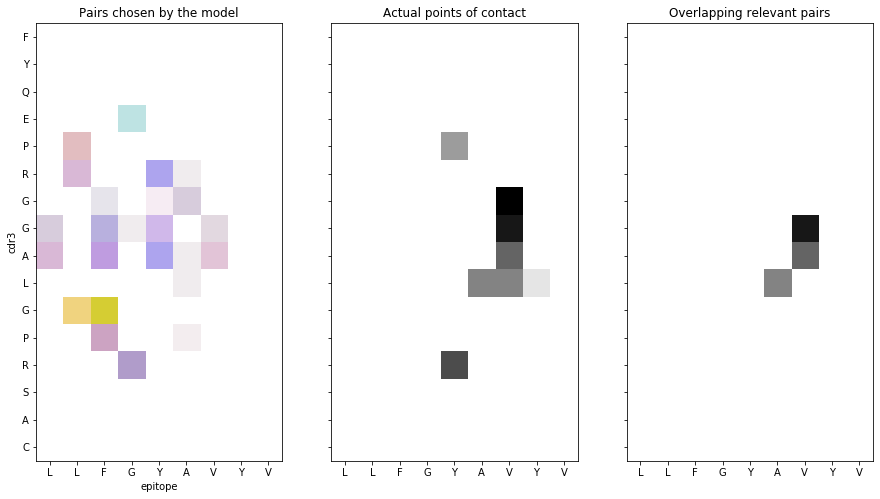

1QSE_C-E.txt
CASRPGLAGGRPEQYF LLFGYPRYV
   Res1 Res2  Off1  Off2
0     Q    F    13     2
1     E    P    12     5
2     R    L    10     0
3     G    F     9     2
4     G    G     9     3
5     G    P     9     5
6     G    L     8     0
7     G    L     8     1
8     G    G     8     3
9     G    Y     8     4
10    G    R     8     6
11    A    L     7     0
12    A    F     7     2
13    A    G     7     3
14    A    Y     7     4
15    A    P     7     5
16    L    L     6     1
17    L    F     6     2
18    L    G     6     3
19    L    Y     6     4
20    L    P     6     5
21    L    R     6     6
22    G    L     5     1
23    G    F     5     2
24    G    G     5     3
25    G    Y     5     4
26    G    P     5     5
27    P    F     4     2
28    P    G     4     3
  Res1 Res2  Off1  Off2  Distance
0    G    R     9     6   2.54933
1    A    R     7     6   2.83217
2    G    R     5     6   2.84306
3    L    Y     6     7   3.35322
4    P    Y    11     4   3.47037
5    P

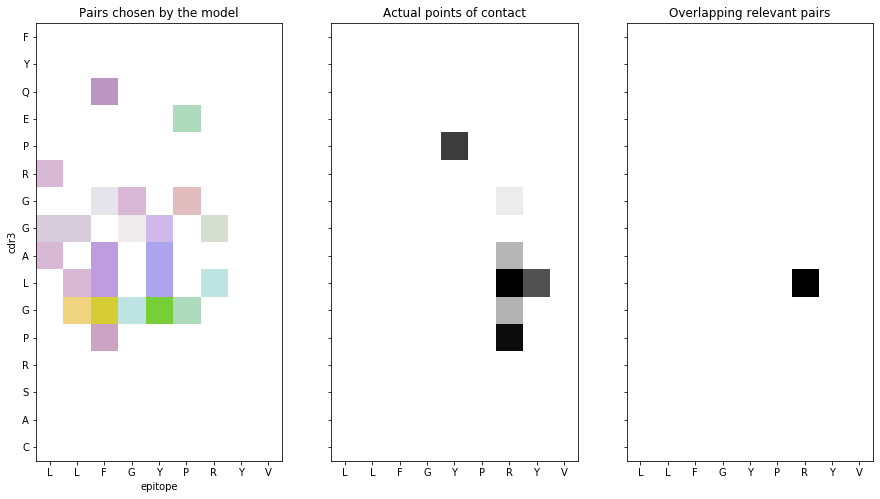

1QSF_C-E.txt
CASRPGLAGGRPEQYF LLFGYPVAV
   Res1 Res2  Off1  Off2
0     E    G    12     3
1     P    G    11     3
2     R    L    10     1
3     R    Y    10     4
4     R    P    10     5
5     G    L     9     0
6     G    F     9     2
7     G    G     9     3
8     G    Y     9     4
9     G    P     9     5
10    G    L     8     1
11    G    F     8     2
12    G    G     8     3
13    G    Y     8     4
14    A    L     7     0
15    A    L     7     1
16    A    F     7     2
17    A    G     7     3
18    A    Y     7     4
19    L    L     6     1
20    L    F     6     2
21    L    G     6     3
22    L    Y     6     4
23    L    P     6     5
24    G    L     5     1
25    G    F     5     2
26    G    Y     5     4
27    P    F     4     2
28    P    G     4     3
  Res1 Res2  Off1  Off2  Distance
0    P    Y    11     4   3.14262
1    G    V     8     6   3.83503
Empty DataFrame
Columns: [Res1, Res2, Off1, Off2, Distance]
Index: []


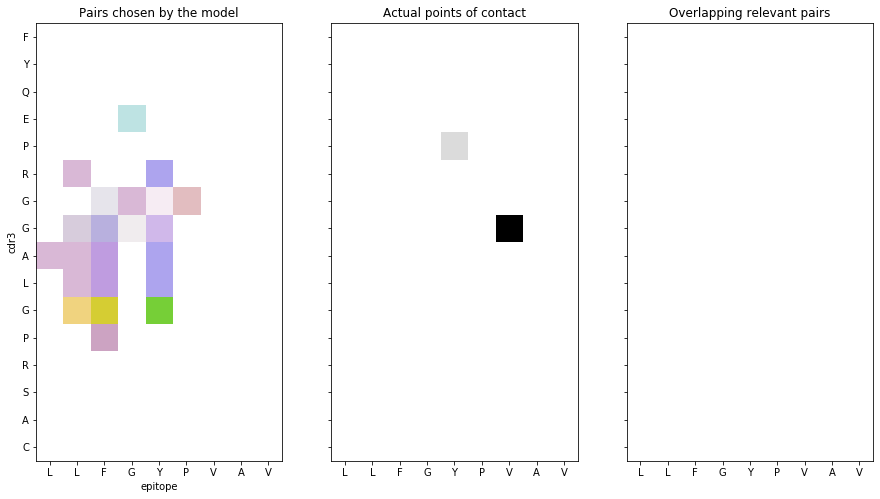

2BNQ_C-E.txt
CASSYVGNTGELFF SLLMWITQV
   Res1 Res2  Off1  Off2
0     E    L    10     1
1     E    W    10     4
2     G    S     9     0
3     G    M     9     3
4     G    W     9     4
5     T    L     8     1
6     T    L     8     2
7     T    M     8     3
8     T    W     8     4
9     T    I     8     5
10    T    Q     8     7
11    N    L     7     1
12    N    L     7     2
13    N    M     7     3
14    N    W     7     4
15    N    I     7     5
16    N    T     7     6
17    G    S     6     0
18    G    L     6     1
19    G    M     6     3
20    G    I     6     5
21    G    T     6     6
22    V    S     5     0
23    V    L     5     1
24    Y    M     4     3
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.81763
1    V    I     5     5   2.85087
2    V    W     5     4   3.14438
3    G    I     6     5   3.20004
4    G    W     6     4   3.53912
5    Y    Q     4     7   3.54080
6    V    M     5     3   3.76975
7    G    T     6     6   3.78835
8    Y

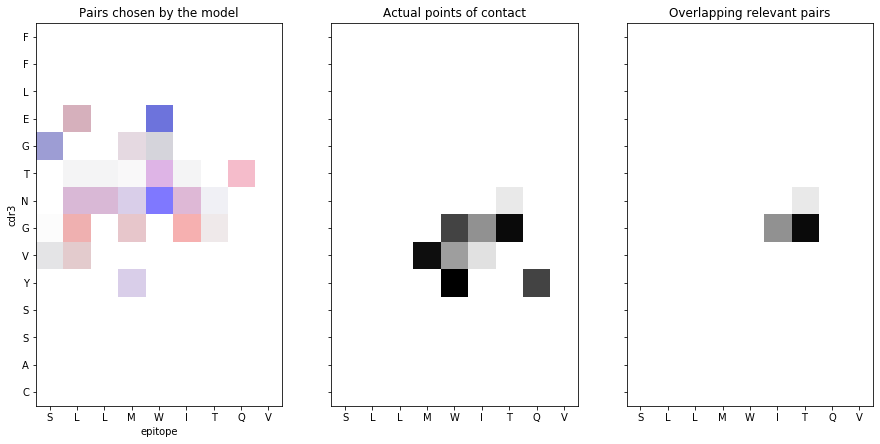

2BNR_C-E.txt
CASSYVGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    I    10     5
1     G    L     9     1
2     G    L     9     2
3     G    M     9     3
4     G    W     9     4
5     T    L     8     1
6     T    L     8     2
7     T    M     8     3
8     T    W     8     4
9     T    I     8     5
10    N    L     7     1
11    N    L     7     2
12    N    M     7     3
13    N    W     7     4
14    N    T     7     6
15    G    S     6     0
16    G    L     6     1
17    G    L     6     2
18    G    M     6     3
19    G    W     6     4
20    G    I     6     5
21    V    L     5     1
22    V    L     5     2
23    V    M     5     3
24    V    I     5     5
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.78764
1    V    I     5     5   2.87486
2    V    W     5     4   3.19545
3    G    I     6     5   3.40202
4    G    W     6     4   3.50872
5    Y    Q     4     7   3.51621
6    G    T     6     6   3.76812
7    V    M     5     3   3.87644
8    Y

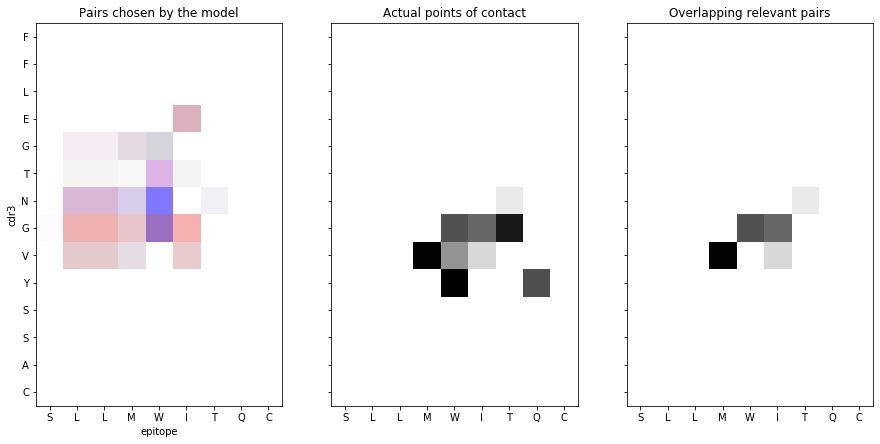

2ESV_P-E.txt
CASSQDRDTQYF VMAPRTLIL
   Res1 Res2  Off1  Off2
0     Q    M     9     1
1     Q    P     9     3
2     Q    R     9     4
3     T    M     8     1
4     T    A     8     2
5     T    P     8     3
6     T    R     8     4
7     D    A     7     2
8     D    P     7     3
9     D    R     7     4
10    R    V     6     0
11    R    M     6     1
12    R    A     6     2
13    R    P     6     3
14    R    T     6     5
15    D    P     5     3
16    D    R     5     4
17    Q    A     4     2
18    Q    P     4     3
19    Q    R     4     4
20    Q    T     4     5
21    S    A     3     2
  Res1 Res2  Off1  Off2  Distance
0    R    T     6     5   2.90445
1    D    R     5     4   3.10002
2    D    R     7     4   3.13537
3    R    R     6     4   3.32098
4    R    I     6     7   3.52459
  Res1 Res2  Off1  Off2  Distance
0    D    R     7     4   3.13537
1    R    T     6     5   2.90445
2    D    R     5     4   3.10002


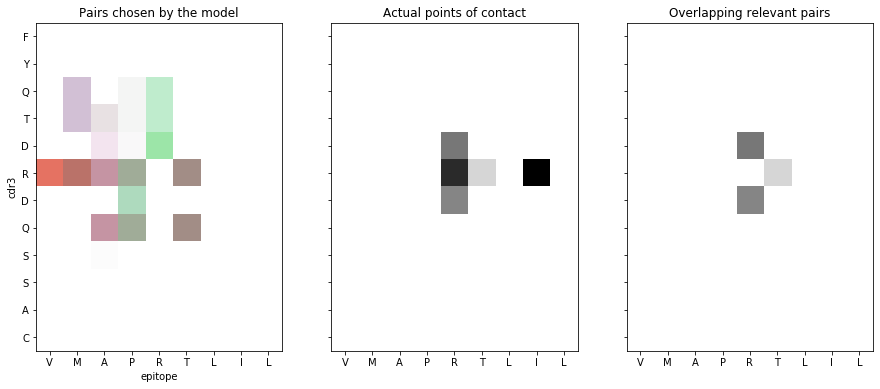

2F53_C-E.txt
CASSYVGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    L    10     2
1     E    W    10     4
2     G    L     9     1
3     G    M     9     3
4     G    W     9     4
5     T    S     8     0
6     T    L     8     2
7     T    M     8     3
8     T    W     8     4
9     T    I     8     5
10    T    T     8     6
11    N    S     7     0
12    N    L     7     1
13    N    L     7     2
14    N    M     7     3
15    N    W     7     4
16    N    I     7     5
17    N    T     7     6
18    G    S     6     0
19    G    L     6     1
20    G    W     6     4
21    G    I     6     5
22    V    L     5     1
23    V    I     5     5
24    Y    I     4     5
  Res1 Res2  Off1  Off2  Distance
0    V    I     5     5   2.77627
1    N    T     7     6   2.78791
2    V    W     5     4   3.20726
3    G    I     6     5   3.43220
4    Y    Q     4     7   3.44754
5    G    W     6     4   3.52580
6    G    T     6     6   3.78183
7    Y    W     4     4   3.89531
8    V

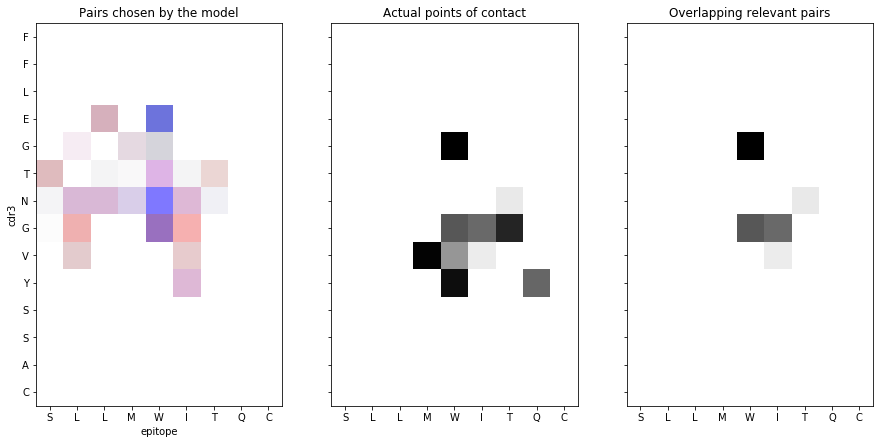

2F54_C-E.txt
CASSYVGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    L    10     1
1     G    S     9     0
2     G    M     9     3
3     G    W     9     4
4     T    L     8     2
5     T    M     8     3
6     T    W     8     4
7     T    I     8     5
8     T    T     8     6
9     N    S     7     0
10    N    L     7     1
11    N    M     7     3
12    N    W     7     4
13    N    I     7     5
14    N    T     7     6
15    G    L     6     1
16    G    L     6     2
17    G    M     6     3
18    G    W     6     4
19    G    I     6     5
20    V    S     5     0
21    V    L     5     1
22    V    L     5     2
23    V    M     5     3
24    V    I     5     5
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.68829
1    V    I     5     5   3.24722
2    V    W     5     4   3.29622
3    G    I     6     5   3.45146
4    Y    Q     4     7   3.63289
5    G    W     6     4   3.73073
6    G    T     6     6   3.80848
7    V    M     5     3   3.94659
  Res1

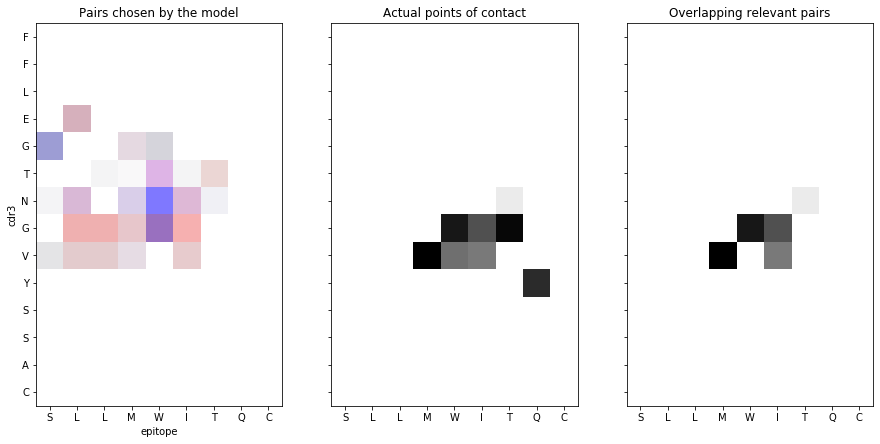

2GJ6_C-E.txt
CASRPGLAGGRPEQYF LLFGKPVYV
   Res1 Res2  Off1  Off2
0     P    L    11     1
1     P    G    11     3
2     R    L    10     1
3     R    P    10     5
4     G    L     9     0
5     G    F     9     2
6     G    K     9     4
7     G    V     9     6
8     G    L     8     0
9     G    L     8     1
10    G    F     8     2
11    G    G     8     3
12    G    K     8     4
13    A    L     7     0
14    A    F     7     2
15    A    G     7     3
16    A    K     7     4
17    A    P     7     5
18    L    F     6     2
19    L    G     6     3
20    L    V     6     6
21    G    L     5     0
22    G    L     5     1
23    G    F     5     2
24    G    G     5     3
25    P    F     4     2
26    P    G     4     3
27    P    P     4     5
28    R    G     3     3
  Res1 Res2  Off1  Off2  Distance
0    G    K     5     4   2.88673
1    L    Y     6     7   3.14089
2    L    V     6     6   3.35233
3    P    K    11     4   3.76709
4    A    V     7     6   3.89097
5    L

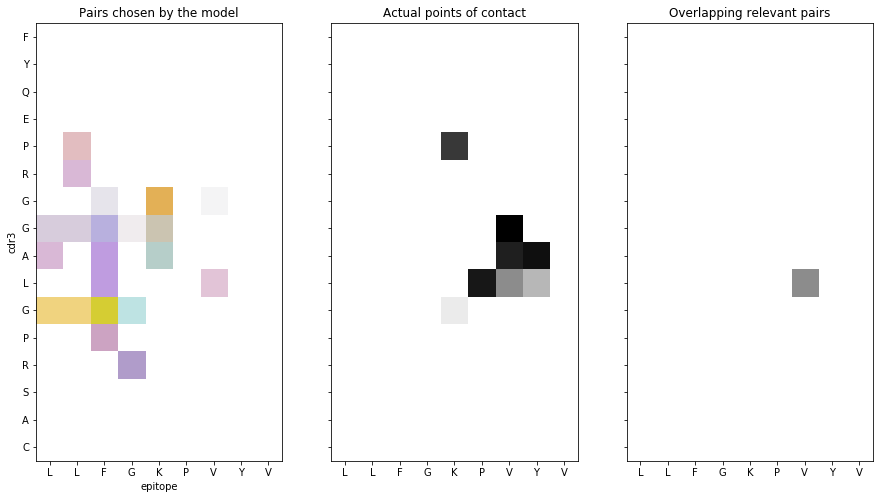

2NX5_C-E.txt
CATGTGDSNQPQHF EPLPQGQLTAY
   Res1 Res2  Off1  Off2
0     Q    L     9     2
1     Q    P     9     3
2     Q    Q     9     4
3     N    P     8     1
4     N    L     8     2
5     N    P     8     3
6     N    Q     8     4
7     S    L     7     2
8     S    P     7     3
9     S    Q     7     4
10    S    G     7     5
11    D    P     6     1
12    D    L     6     2
13    D    P     6     3
14    D    Q     6     4
15    D    G     6     5
16    D    Q     6     6
17    D    L     6     7
18    G    P     5     1
19    G    L     5     2
20    G    P     5     3
21    G    Q     5     4
22    G    G     5     5
23    G    Q     5     6
24    T    L     4     2
25    T    Q     4     4
26    T    G     4     5
27    G    Q     3     4
28    G    G     3     5
29    T    P     2     3
30    T    Q     2     4
  Res1 Res2  Off1  Off2  Distance
0    D    Q     6     6   2.37391
1    T    Q     4     6   3.15038
2    D    Q     6     4   3.41524
3    G    Q     5     4 

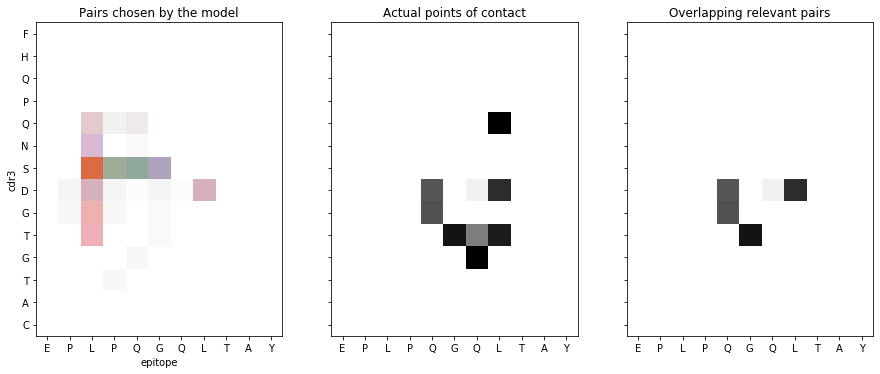

2P5E_C-E.txt
CASSYLGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    W    10     4
1     G    S     9     0
2     G    L     9     1
3     G    L     9     2
4     G    M     9     3
5     G    W     9     4
6     T    L     8     2
7     T    M     8     3
8     T    W     8     4
9     T    I     8     5
10    N    S     7     0
11    N    L     7     1
12    N    M     7     3
13    N    W     7     4
14    N    I     7     5
15    N    T     7     6
16    G    L     6     1
17    G    L     6     2
18    G    M     6     3
19    G    I     6     5
20    L    S     5     0
21    L    L     5     1
22    L    M     5     3
23    L    I     5     5
24    Y    M     4     3
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.66963
1    L    I     5     5   3.00185
2    Y    Q     4     7   3.40190
3    L    W     5     4   3.44250
4    G    I     6     5   3.44322
5    G    W     6     4   3.58041
6    G    T     6     6   3.65971
7    Y    W     4     4   3.97680
  Res1

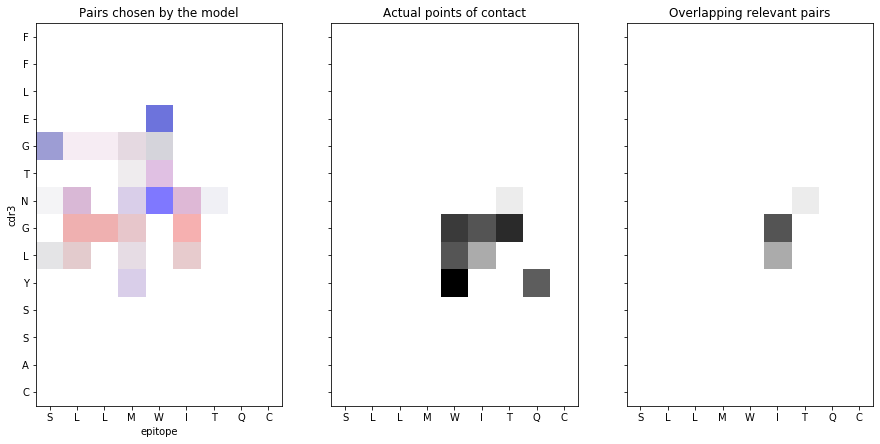

2P5W_C-E.txt
CASSYLGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    L    10     1
1     E    W    10     4
2     G    L     9     1
3     G    M     9     3
4     G    W     9     4
5     T    L     8     1
6     T    L     8     2
7     T    M     8     3
8     T    W     8     4
9     T    I     8     5
10    N    S     7     0
11    N    L     7     1
12    N    L     7     2
13    N    M     7     3
14    N    W     7     4
15    N    I     7     5
16    G    L     6     1
17    G    L     6     2
18    G    M     6     3
19    G    W     6     4
20    G    I     6     5
21    L    S     5     0
22    L    L     5     1
23    L    L     5     2
24    L    I     5     5
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.66039
1    L    I     5     5   2.97463
2    L    W     5     4   3.45825
3    G    I     6     5   3.49971
4    Y    Q     4     7   3.51537
5    G    W     6     4   3.51713
6    G    T     6     6   3.60702
7    Y    W     4     4   3.92066
  Res1

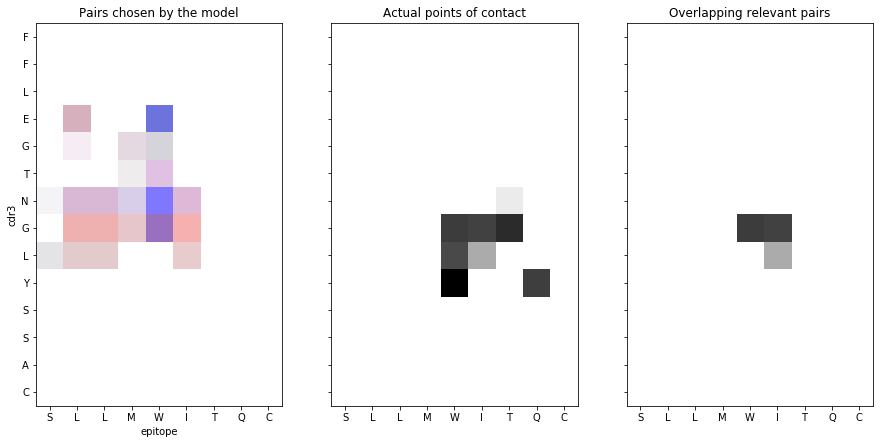

2PYE_C-E.txt
CASSYLGNTGELFF SLLMWITQC
   Res1 Res2  Off1  Off2
0     E    L    10     1
1     E    M    10     3
2     G    L     9     1
3     G    M     9     3
4     G    W     9     4
5     G    I     9     5
6     T    L     8     1
7     T    L     8     2
8     T    M     8     3
9     T    W     8     4
10    T    I     8     5
11    N    L     7     1
12    N    L     7     2
13    N    M     7     3
14    G    S     6     0
15    G    L     6     1
16    G    L     6     2
17    G    M     6     3
18    G    I     6     5
19    L    L     5     1
20    L    M     5     3
21    L    W     5     4
22    L    I     5     5
23    Y    L     4     1
24    Y    M     4     3
  Res1 Res2  Off1  Off2  Distance
0    N    T     7     6   2.87531
1    L    I     5     5   2.99446
2    G    W     6     4   3.47115
3    G    I     6     5   3.47787
4    L    W     5     4   3.50155
5    Y    Q     4     7   3.57920
6    G    T     6     6   3.86268
7    Y    W     4     4   3.91757
  Res1

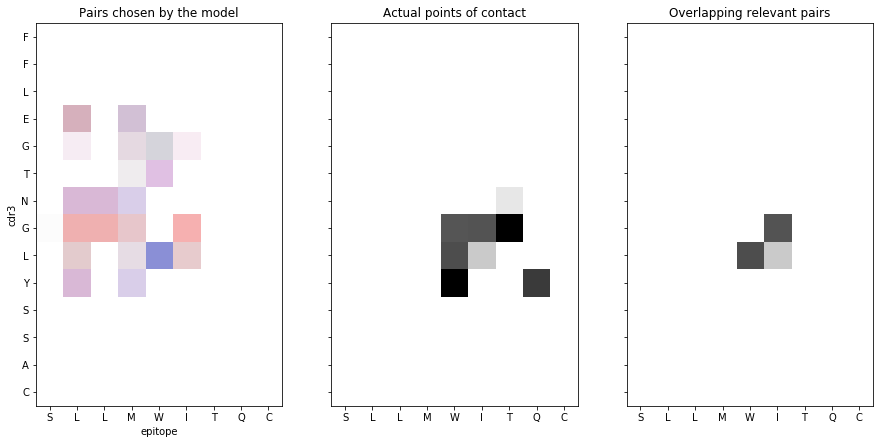

2VLJ_C-E.txt
CASSSRSSYEQYF GILGFVFTL
   Res1 Res2  Off1  Off2
0     Q    L    10     2
1     E    I     9     1
2     E    L     9     2
3     Y    I     8     1
4     Y    L     8     2
5     Y    G     8     3
6     Y    F     8     4
7     S    I     7     1
8     S    L     7     2
9     S    G     7     3
10    S    F     7     4
11    S    V     7     5
12    S    G     6     0
13    S    I     6     1
14    S    L     6     2
15    S    G     6     3
16    S    F     6     4
17    R    G     5     0
18    R    I     5     1
19    R    L     5     2
20    R    V     5     5
21    S    V     4     5
22    S    F     3     4
23    S    V     3     5
  Res1 Res2  Off1  Off2  Distance
0    S    V     6     5   3.03096
1    R    F     5     4   3.90131
2    S    F     7     4   3.94516
  Res1 Res2  Off1  Off2  Distance
0    S    F     7     4   3.94516


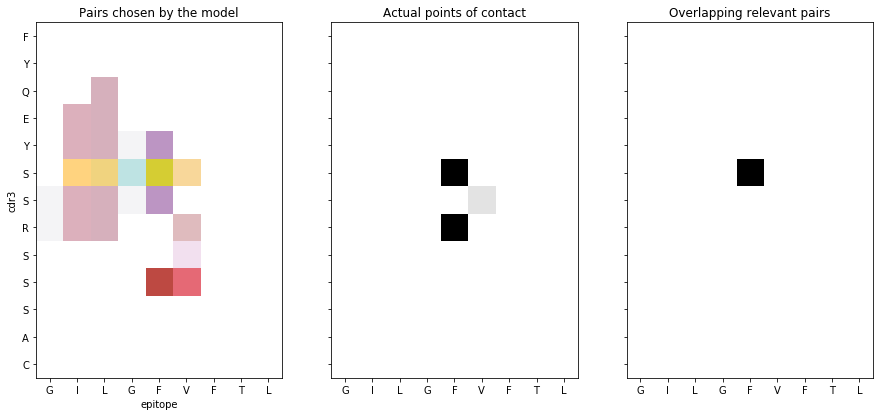

2VLK_C-E.txt
CASSSRSSYEQYF GILGFVFTL
   Res1 Res2  Off1  Off2
0     Q    I    10     1
1     E    I     9     1
2     E    L     9     2
3     E    F     9     4
4     Y    I     8     1
5     Y    L     8     2
6     Y    G     8     3
7     Y    F     8     4
8     Y    V     8     5
9     S    I     7     1
10    S    L     7     2
11    S    G     7     3
12    S    F     7     4
13    S    V     7     5
14    S    I     6     1
15    S    L     6     2
16    S    G     6     3
17    S    F     6     4
18    S    V     6     5
19    R    G     5     0
20    R    V     5     5
21    S    V     4     5
22    S    F     3     4
23    S    L     2     2
  Res1 Res2  Off1  Off2  Distance
0    S    V     6     5   3.00551
1    R    F     5     6   4.18101
  Res1 Res2  Off1  Off2  Distance
0    S    V     6     5   3.00551


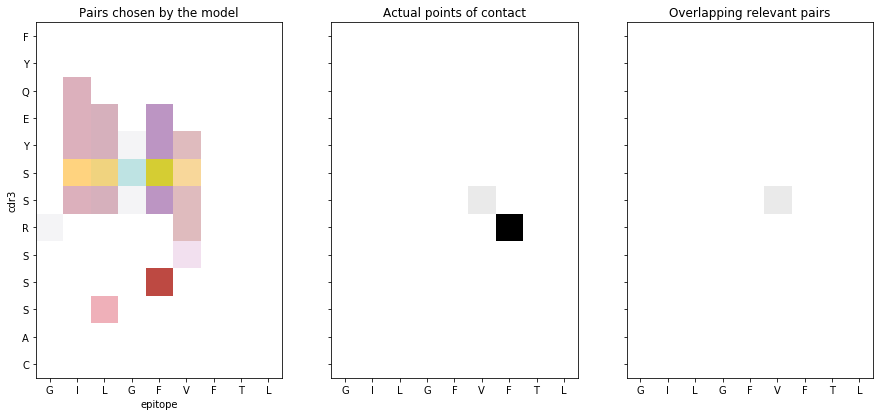

2VLR_C-E.txt
CASSSRASYEQYF GILGFVFTL
   Res1 Res2  Off1  Off2
0     Q    L    10     2
1     E    I     9     1
2     E    L     9     2
3     E    F     9     4
4     Y    I     8     1
5     Y    L     8     2
6     Y    G     8     3
7     Y    F     8     4
8     Y    V     8     5
9     Y    T     8     7
10    S    I     7     1
11    S    L     7     2
12    S    G     7     3
13    S    F     7     4
14    S    V     7     5
15    A    I     6     1
16    A    L     6     2
17    A    G     6     3
18    R    G     5     0
19    R    I     5     1
20    R    L     5     2
21    R    V     5     5
22    S    V     4     5
23    S    F     4     6
  Res1 Res2  Off1  Off2  Distance
0    S    F     7     4   3.96672
1    R    F     5     6   4.03739
  Res1 Res2  Off1  Off2  Distance
0    S    F     7     4   3.96672


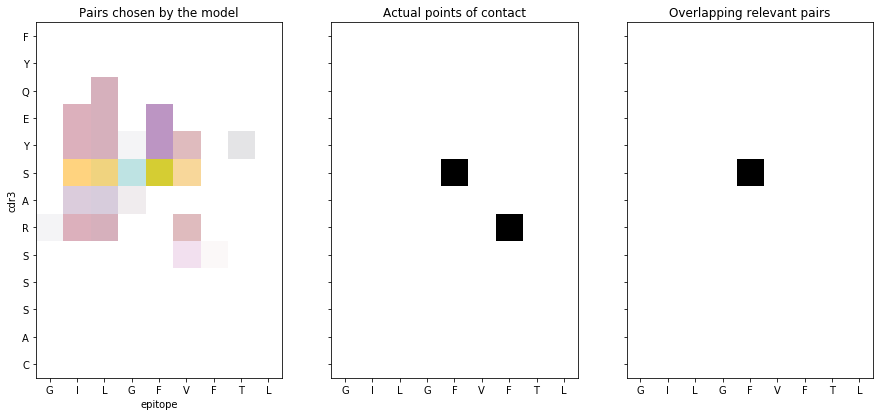

2YPL_C-E.txt
CASTGSYGYTF KAFSPEVIPMF
   Res1 Res2  Off1  Off2
0     F    F    10     2
1     T    S     9     3
2     T    V     9     6
3     Y    F     8     2
4     Y    P     8     4
5     G    F     7     2
6     G    S     7     3
7     G    P     7     4
8     Y    S     6     3
9     Y    P     6     4
10    S    A     5     1
11    S    F     5     2
12    S    S     5     3
13    S    P     5     4
14    S    E     5     5
15    G    F     4     2
16    G    S     4     3
17    G    I     4     7
18    T    S     3     3
19    T    P     3     4
20    T    E     3     5
21    S    A     2     1
22    S    S     2     3
23    A    P     1     4
  Res1 Res2  Off1  Off2  Distance
0    S    V     5     6   3.53343
1    Y    V     6     6   3.59746
2    Y    E     6     5   4.04620
Empty DataFrame
Columns: [Res1, Res2, Off1, Off2, Distance]
Index: []


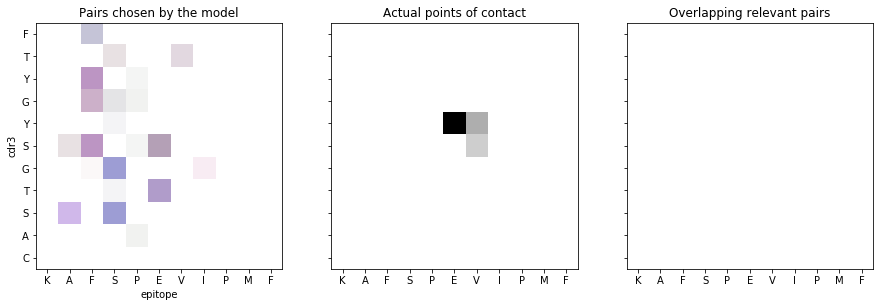

In [65]:
################
import scipy.stats as stats

obs = []
exp = []

################
data_3D = [] 


baseline = tf.zeros(shape=(20,11,4))
integrated_gradients = saliency.IntegratedGradients()


for i, comp in comps.iterrows():
    
    # load contact txt file
    contacts = pd.read_csv('./contacts/' + str(comp['contact_file']), delimiter = "\t")
    print(str(comp['contact_file']))
    # convert mappings
    contacts.replace({"ResNum2": mappings[i]}, inplace = True)
    contacts['ResNum2'] = (contacts['ResNum2'] - comp['CDR3_start']).astype('int32')
    contacts['ResNum1'] = (contacts['ResNum1'] - 1).astype('int32')
    
    best = pd.DataFrame({'Res1': contacts['Res2'].tolist(),
                         'Res2': contacts['Res1'].tolist(),
                         'Off1': contacts['ResNum2'].tolist(),
                         'Off2': contacts['ResNum1'].tolist(),
                        'Distance': contacts['Distance'].tolist()}).sort_values(by='Distance')
    
    # extract relevant pairs
    im = analysis_3D[i]
    

    # Compute the vanilla mask.
    
    #vanilla_integrated_gradients_mask_3d = integrated_gradients.GetMask(im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=20)
    
    
    #vanilla_integrated_gradients_mask_3d = guided_ig.GetMask(im, call_model_function, call_model_args, x_steps=25, x_baseline=baseline, max_dist=1.0, fraction=0.5)
    
    #vanilla_integrated_gradients_mask_3d = gradient_saliency.GetMask(im, call_model_function, call_model_args)
    
    vanilla_integrated_gradients_mask_3d = gradient_saliency.GetSmoothedMask(im, call_model_function, call_model_args)
    
    #vanilla_integrated_gradients_mask_3d = blur_ig.GetMask(im, call_model_function, call_model_args, batch_size=20)
    
    #vanilla_integrated_gradients_mask_3d = integrated_gradients.GetSmoothedMask(im, call_model_function, call_model_args, x_steps=40, x_baseline=baseline, batch_size=10)
    
    

    
    
    # Call the visualization methods to convert the 3D tensor to 2D grayscale.
    vanilla_mask_grayscale = saliency.VisualizeImageGrayscale(vanilla_integrated_gradients_mask_3d)
    

    im_mask = np.array(im)

    mask = (im_mask != 0.0).all(axis=(2))
    im_mask = im_mask[(mask == True).any(axis=1),:]
    im_mask = im_mask[:,(mask == True).any(axis=0)]

    vanilla_mask_grayscale = vanilla_mask_grayscale[(mask == True).any(axis=1),:]
    vanilla_mask_grayscale = vanilla_mask_grayscale[:,(mask == True).any(axis=0)]

    r_mask = vanilla_mask_grayscale > np.percentile(vanilla_mask_grayscale, 80)
    
    data_3D = extract_pairs(r_mask, vanilla_mask_grayscale, im_mask,
                              comps['cdr3'][i], comps['antigen.epitope'][i])
    data_3D = pd.DataFrame(data_3D)
    cdr3 = data_3D['cdr3'][0]
    epitope = data_3D['epitope'][0] 
    print(cdr3,epitope)
    data_3D.drop(columns = ['cdr3', 'epitope', 'gray_value', 'property1', 'property2', 'property3', 'property4'], inplace = True)
    print(data_3D)
    
    # remove negative values
    best.drop(best[best['Off1'] < 0.0].index, inplace=True)
    best.drop(best[best['Off2'] < 0.0].index, inplace=True)
    # remove 'HOH' value
    best.drop(best[best['Res1'] == 'HOH'].index, inplace=True)
    best.drop(best[best['Res2'] == 'HOH'].index, inplace=True)
    best.drop(best[best['Res2'] == '3IB'].index, inplace=True)
    
    # drop rows that have offsets that escape the sequences
    best.drop(best[best['Off1'] > len(cdr3)].index, inplace=True)
    best.drop(best[best['Off2'] > len(epitope)].index, inplace=True)
    
    best.drop_duplicates(subset=['Res1','Res2','Off1','Off2'],inplace = True)
    best.reset_index(drop=True, inplace=True)
    print(best)
    
    found = pd.merge(data_3D, best, on=['Res1','Res2','Off1','Off2'])
    print(found)
    
    
    contact_mask = np.zeros(r_mask.shape)
    found_mask = np.zeros(r_mask.shape) 
    for i,el in best.iterrows():
        contact_mask[-el['Off1']-1,el['Off2']] = el['Distance']+0.1
    for i,el in found.iterrows():
        found_mask[-el['Off1']-1,el['Off2']] = el['Distance']+0.1
        
    ################
    exp.append(best.shape[0]/5)
    obs.append(found.shape[0])
    ################
          
    max_image = max(best['Distance'])
    min_image = min(best['Distance'])
    fig,(ax, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=True)
    
    im_mask[~r_mask] = 0
    img = ax.imshow(im_mask)
    
    img2 = ax2.imshow(1-(contact_mask-min_image)/(max_image-min_image), cmap=P.cm.gray, vmin=0, vmax=1)
    img3 = ax3.imshow(1-(found_mask-min_image)/(max_image-min_image), cmap=P.cm.gray, vmin=0, vmax=1)


    ax.set_xticks(np.arange(len(epitope)))
    ax.set_yticks(np.arange(len(cdr3)))
    ax.set_yticklabels(cdr3[::-1])
    ax.set_ylabel('cdr3')
    ax.set_xlabel('epitope')
    ax.set_xticklabels(epitope)
    ax.set_title("Pairs chosen by the model")
    ax2.set_title("Actual points of contact")
    ax3.set_title("Overlapping relevant pairs")

    fig.set_figheight(10)
    fig.set_figwidth(15)
    plt.show()

In [66]:
scipy.stats.ttest_ind(obs, exp) # ttest to identify if there's a significative difference between the means



Ttest_indResult(statistic=2.90481509079883, pvalue=0.005959212701783039)

In [69]:
print(obs)
print(exp)

[1, 3, 1, 2, 3, 1, 0, 3, 5, 3, 5, 5, 1, 5, 3, 3, 3, 1, 1, 1, 0]
[1.6, 1.6, 1.0, 0.8, 1.6, 1.4, 0.4, 1.8, 1.8, 1.0, 2.0, 1.6, 1.6, 1.8, 1.6, 1.6, 1.6, 0.6, 0.4, 0.4, 0.6]
